In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
plt.style.use('ggplot')
#pd.set_option('max_rows',200) 
pd.set_option('display.float_format', '{:.4f}'.format) # Set decimals 


# Plot choices
sns.set(style="whitegrid")

In [2]:
# Load data
cars = pd.read_csv('cars.csv')
labs = pd.read_csv('labels_values.csv')
dict_varnames = pd.read_csv('labels_variables.csv').set_index('variable').to_dict()['label']

# to translate market indices to names of countries 
labs.index += 1 
dict_ma = labs.market.dropna().to_dict()

cars['country'] = cars['ma'].map(dict_ma)

# Recalculate 'qu_total' with correct country mapping STYR PÅ DEN HER

cars['qu_total'] = cars.groupby(['ma','ye'])['qu'].transform('sum')
#cars['qu_total'] = cars.groupby(['country', 'ye'])['qu'].transform('sum')

# Calculate 's' with the newly defined 'qu_total'
cars['s'] = cars['qu'] / cars['qu_total']

# Data cleaning - replacing commas and converting to float
columns_to_clean = ['hp', 'li', 'li1', 'li2', 'li3', 'ngdp', 'rgdp', 'princ', 'pr', 'tax', 'avdexr', 'ac', 'le', 'sp']
for column in columns_to_clean:
    if column in cars.columns:
        cars[column] = cars[column].str.replace(',', '.').astype(float)

cars['log_s'] = np.log(cars['s']) #/(0.5)

dict_cla = labs.classs.dropna().to_dict()
cars['class'] = cars['cla'].map(dict_cla)



# 'avg_km': how many km is avg in each market 
market_annual_driving = {
    1: 11300,
    2: 11300,
    3: 11300,
    4: 11300,
    5: 11300
}

# Map annual kilometers to cars data
cars['ann_km'] = cars['ma'].map(market_annual_driving)

# Load oil prices and calculate fuel price per liter
oil = pd.read_csv('oilPriceDollars.csv')
oil['ye'] = oil['Year'].astype(str).str[-2:].astype(int)

#Måske ændre dette
fuel_from_oil = 158 * 0.43  # L from barrel * energy content factor

# Fuel price for 1L 
oil['Fuel_price_1L'] = (oil['priceDollars'] / fuel_from_oil)

# Merge cars data with oil prices
cars = cars.merge(oil, on='ye', how='left')

# Calculate annual fuel cost in dollars
cars['Fuel_price_ann_dollar'] = cars['Fuel_price_1L'] * cars['ann_km'] * (cars['li'] / 100)

# Adjust car prices using 'princ'
cars['pr_dollar'] = cars['pr'] / cars['princ']

# Adjust car prices by GDP per capita
cars['pr_dollar_inc'] = cars['pr_dollar'] / ((cars['ngdp'] / cars['princ']) / cars['pop'])

# Output the modified DataFrame
cars

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,s,log_s,class,ann_km,Year,priceDollars,Fuel_price_1L,Fuel_price_ann_dollar,pr_dollar,pr_dollar_inc
0,83,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0024,-6.0394,compact,11300,1983,26.1900,0.3855,338.3164,424827.6057,0.7915
1,84,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0056,-5.1899,compact,11300,1984,25.8800,0.3809,334.3119,457667.3059,0.7620
2,85,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0052,-5.2586,compact,11300,1985,24.0900,0.3546,311.1891,490304.2533,0.7363
3,86,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0058,-5.1517,compact,11300,1986,12.5100,0.1841,161.6013,515709.9505,0.6591
4,87,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0057,-5.1745,compact,11300,1987,15.4000,0.2267,203.2026,538875.3868,0.6493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,5,955,291,31,volvo S80,volvo,S80,6,1,...,0.0020,-6.2033,luxury,11300,1999,15.5600,0.2290,222.5671,15289.8627,1.5000
11545,99,5,977,229,23,rover 75,rover,75,7,12,...,0.0043,-5.4443,standard,11300,1999,15.5600,0.2290,238.9577,15289.8636,1.1956
11546,99,5,978,287,29,toyota yaris,toyota,yaris,4,6,...,0.0092,-4.6881,subcompact,11300,1999,15.5600,0.2290,181.1593,15289.8632,0.4902
11547,99,5,979,306,30,volkswagen lupo,VW,lupo,2,4,...,0.0025,-5.9931,subcompact,11300,1999,15.5600,0.2290,172.5326,15289.8633,0.5128


In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Assuming `cars` is your DataFrame and has been previously defined
# Ensure your DataFrame 'cars' has the necessary columns and data

countries = ['Belgium', 'France', 'Germany', 'Italy', 'UK']

# List of attributes including 'li' and 'Fuel_price_ann_dollar'
attributes = ['we', 'hp', 'li']

# Relevant columns are cleaned for NaN and infinite values
cars[attributes + ['princ']] = cars[attributes + ['princ']].replace([np.inf, -np.inf], np.nan)
cars.dropna(subset=attributes + ['princ'], inplace=True)

# Store results
country_attribute_effects = {}

# Loop through each country and attribute to run separate regressions
for country in countries:
    print(f"------ {country} ------")
    country_attribute_effects[country] = {}
    cars_country = cars[cars['country'] == country]  # Filter data for the specific country

    for attr in attributes:
        # Add a constant to the model to capture the intercept
        X = sm.add_constant(cars_country[[attr]])  # Include only the specific attribute

        # 'princ' is the dependent variable
        y = cars_country['princ']

        # Fit multivariate linear regression model
        model = sm.OLS(y, X).fit()

        # Save the coefficient for the attribute
        country_attribute_effects[country][attr] = model.params[attr]
    
    # Print model summary for the country
    print(f"Effects for {country}:")
    for attr, effect in country_attribute_effects[country].items():
        print(f"Effect of {attr}: {effect:.4f}")
    print("\n")

# Now, you can access `country_attribute_effects` to see the effects for each attribute in each country


------ Belgium ------
Effects for Belgium:
Effect of we: 0.0012
Effect of hp: 0.0123
Effect of li: 0.1241


------ France ------
Effects for France:
Effect of we: 0.0012
Effect of hp: 0.0121
Effect of li: 0.1308


------ Germany ------
Effects for Germany:
Effect of we: 0.0010
Effect of hp: 0.0101
Effect of li: 0.1034


------ Italy ------
Effects for Italy:
Effect of we: 0.0016
Effect of hp: 0.0155
Effect of li: 0.2193


------ UK ------
Effects for UK:
Effect of we: 0.0016
Effect of hp: 0.0158
Effect of li: 0.1853




In [4]:
print(cars.columns)

Index(['ye', 'ma', 'co', 'zcode', 'brd', 'type', 'brand', 'model', 'org',
       'loc', 'cla', 'home', 'frm', 'qu', 'cy', 'hp', 'we', 'pl', 'do', 'le',
       'wi', 'he', 'li1', 'li2', 'li3', 'li', 'sp', 'ac', 'pr', 'princ',
       'eurpr', 'exppr', 'avexr', 'avdexr', 'avcpr', 'avppr', 'avdcpr',
       'avdppr', 'xexr', 'tax', 'pop', 'ngdp', 'rgdp', 'engdp', 'ergdp',
       'engdpc', 'ergdpc', 'country', 'qu_total', 's', 'log_s', 'class',
       'ann_km', 'Year', 'priceDollars', 'Fuel_price_1L',
       'Fuel_price_ann_dollar', 'pr_dollar', 'pr_dollar_inc'],
      dtype='object')


- Få styr på cars['qu_total']

# Discriptive analysis for Fuel prices

In [5]:
## Prepare summary statistics for the table
aggregation_dict = {
    'pop': 'mean',
    'qu': 'size',
    's': 'mean',
    'pr_dollar': 'mean',
    'pr_dollar_inc': 'mean',
    'li': 'mean',
    'Fuel_price_ann_dollar': 'mean'
}

if 'weight' in cars.columns:
    aggregation_dict['weight'] = 'mean'
if 'size' in cars.columns:
    aggregation_dict['size'] = 'mean'

summary_stats = cars.groupby('country').agg(aggregation_dict).rename(columns={
    'pop': 'Avg. population (million pers.)',
    'qu': 'No. of observations',
    's': 'Share of total sales',
    'pr_dollar': 'Avg. price',
    'pr_dollar_inc': 'Avg. price/inc',
    'li': 'Avg. fuel economy (l/100 km)',
    'Fuel_price_ann_dollar': 'Avg. annual fuel cost/inc'
})

# Add the "All markets" summary
all_markets_summary = pd.DataFrame(summary_stats.mean(axis=0)).T
all_markets_summary.index = ['All markets']
summary_stats = pd.concat([all_markets_summary, summary_stats])

# Reformat the summary table to match the format of the provided image
summary_stats = summary_stats.T

# Display the summary table
summary_stats.index.name = "Table 4.1: Avg. characteristics of national markets"
summary_stats

,All markets,Belgium,France,Germany,Italy,UK
Table 4.1: Avg. characteristics of national markets,,,,,,
Avg. population (million pers.),49466507.8560,9924668.9113,55352335.5408,68467130.9680,56589807.5974,56998596.2625
No. of observations,2309.8000,2673.0000,2265.0000,2283.0000,2027.0000,2301.0000
Share of total sales,0.0131,0.0112,0.0132,0.0131,0.0148,0.0130
Avg. price,3566486.7964,515086.4968,84246.6216,30311.6774,17195590.8734,7198.3129
Avg. price/inc,0.8320,0.7225,0.7481,0.6539,0.9879,1.0476
Avg. fuel economy (l/100 km),8.1761,8.2188,8.1209,8.2405,8.0774,8.2230
Avg. annual fuel cost/inc,201.6274,203.8501,201.9573,199.2018,197.4781,205.6496


In [6]:
import pandas as pd

# Define the aggregation dictionary
aggregation_dict = {
    'pop': 'mean',
    'qu': 'size',
    's': 'sum',
    'pr': 'mean',
    'pr_dollar_inc': 'mean',
    'li': 'mean',
    'Fuel_price_ann_dollar': 'mean',
    'we': 'mean',
    'hp': 'mean',
    'ac': 'mean'
}

# Function to calculate weighted average
def weighted_avg(df, values, weights):
    return (df[values] * df[weights]).sum() / df[weights].sum()

# Prepare a new dataframe for weighted averages
weighted_averages = cars.groupby('country').apply(lambda x: pd.Series({
    'Avg. price': weighted_avg(x, 'pr', 'qu'),
    'Avg. price/inc': weighted_avg(x, 'pr_dollar_inc', 'qu'),
    'Avg. fuel economy (l/100 km)': weighted_avg(x, 'li', 'qu'),
    'Avg. annual fuel cost/inc': weighted_avg(x, 'Fuel_price_ann_dollar', 'qu'),
    'Avg. weight (kg)': weighted_avg(x, 'we', 'qu'),
    'Avg. horsepower': weighted_avg(x, 'hp', 'qu'),
    'Avg. acceleration': weighted_avg(x, 'ac', 'qu')
}))

# Calculate summary statistics
summary_stats = cars.groupby('country').agg(aggregation_dict).rename(columns={
    'pop': 'Avg. population (million pers.)',
    'qu': 'No. of observations',
    's': 'Total sales',
    'pr': 'Avg. price',
    'pr_dollar_inc': 'Avg. price/inc',
    'li': 'Avg. fuel economy (l/100 km)',
    'Fuel_price_ann_dollar': 'Avg. annual fuel cost/inc',
    'we': 'Avg. weight (kg)',
    'hp': 'Avg. horsepower',
    'ac': 'Avg. acceleration'
})

# Calculate total sales for normalization
total_market_sales = summary_stats['Total sales'].sum()

# Calculate market share of total sales for each country
summary_stats['Share of total sales'] = summary_stats['Total sales'] / total_market_sales

# Combine summary statistics with weighted averages
summary_stats.update(weighted_averages)

# Calculate the "All markets" summary using weighted averages
all_markets_summary = pd.Series({
    'Avg. population (million pers.)': weighted_avg(cars, 'pop', 'qu'),
    'No. of observations': cars['qu'].sum(),
    'Total sales': cars['s'].sum(),
    'Share of total sales': 1,
    'Avg. price': weighted_avg(cars, 'pr', 'qu'),
    'Avg. price/inc': weighted_avg(cars, 'pr_dollar_inc', 'qu'),
    'Avg. fuel economy (l/100 km)': weighted_avg(cars, 'li', 'qu'),
    'Avg. annual fuel cost/inc': weighted_avg(cars, 'Fuel_price_ann_dollar', 'qu'),
    'Avg. weight (kg)': weighted_avg(cars, 'we', 'qu'),
    'Avg. horsepower': weighted_avg(cars, 'hp', 'qu'),
    'Avg. acceleration': weighted_avg(cars, 'ac', 'qu')
}).to_frame().T

all_markets_summary.index = ['All markets']

# Concatenate the "All markets" summary with the country-level summaries
summary_stats = pd.concat([all_markets_summary, summary_stats])

# Reformat the summary table
summary_stats = summary_stats.T

# Display the summary table
summary_stats.index.name = "Avg. characteristics of national markets"
summary_stats.reset_index(inplace=True)
summary_stats.columns = summary_stats.columns.map(str)

# Display the dataframe

summary_stats


,Avg. characteristics of national markets,All markets,Belgium,France,Germany,Italy,UK
0,Avg. population (million pers.),58105301.8895,9924668.9113,55352335.5408,68467130.9680,56589807.5974,56998596.2625
1,No. of observations,228823056.0000,2673.0000,2265.0000,2283.0000,2027.0000,2301.0000
2,Total sales,150.0000,30.0000,30.0000,30.0000,30.0000,30.0000
3,Share of total sales,1.0000,0.2000,0.2000,0.2000,0.2000,0.2000
4,Avg. price,2631620.4323,330926.6595,50055.0516,19978.8550,12070426.2099,6522.2324
5,Avg. price/inc,0.7029,0.6380,0.6142,0.6370,0.7413,0.8818
6,Avg. fuel economy (l/100 km),7.6249,7.8101,7.3921,8.0415,7.1470,7.7216
7,Avg. annual fuel cost/inc,187.8797,190.2731,181.6482,194.6993,181.0651,191.3222
8,Avg. weight (kg),918.6209,930.8868,891.5054,980.7129,846.4651,928.7439
9,Avg. horsepower,47.8199,48.8467,44.6252,52.4066,42.9735,49.3982


In [7]:
import pandas as pd

# Define the aggregation dictionary
aggregation_dict = {
    'pop': 'mean',
    'qu': 'size',
    's': 'sum',
    'pr': 'mean',
    'pr_dollar_inc': 'mean',
    'Fuel_price_ann_dollar': 'mean',
    'we': 'mean',
    'hp': 'mean',
    'ac': 'mean',
    'le': 'mean'
}

# Function to calculate weighted average
def weighted_avg(df, values, weights):
    return (df[values] * df[weights]).sum() / df[weights].sum()

# Prepare a new dataframe for weighted averages
weighted_averages = cars.groupby('country').apply(lambda x: pd.Series({
    'Avg. price': weighted_avg(x, 'pr', 'qu'),
    'Avg. price/inc': weighted_avg(x, 'pr_dollar_inc', 'qu'),
    'Avg. annual fuel cost/inc': weighted_avg(x, 'Fuel_price_ann_dollar', 'qu'),
    'Avg. weight (kg)': weighted_avg(x, 'we', 'qu'),
    'Avg. horsepower': weighted_avg(x, 'hp', 'qu'),
    'Avg. acceleration': weighted_avg(x, 'ac', 'qu'),
    'Avg. length': weighted_avg(x, 'le', 'qu')
}))

# Calculate summary statistics
summary_stats = cars.groupby('country').agg(aggregation_dict).rename(columns={
    'pop': 'Avg. population (million pers.)',
    'qu': 'No. of observations',
    's': 'Total sales',
    'pr': 'Avg. price',
    'pr_dollar_inc': 'Avg. price/inc',
    'Fuel_price_ann_dollar': 'Avg. annual fuel cost/inc',
    'we': 'Avg. weight (kg)',
    'hp': 'Avg. horsepower',
    'ac': 'Avg. acceleration',
    'le': 'Avg. length',
})

# Calculate total sales for normalization
total_market_sales = summary_stats['Total sales'].sum()

# Calculate market share of total sales for each country
summary_stats['Share of total sales'] = summary_stats['Total sales'] / total_market_sales

# Combine summary statistics with weighted averages
summary_stats.update(weighted_averages)

# Calculate the "All markets" summary using weighted averages
all_markets_summary = pd.Series({
    'Avg. population (million pers.)': weighted_avg(cars, 'pop', 'qu'),
    'No. of observations': cars['qu'].sum(),
    'Total sales': cars['s'].sum(),
    'Share of total sales': 1,
    'Avg. price': weighted_avg(cars, 'pr', 'qu'),
    'Avg. price/inc': weighted_avg(cars, 'pr_dollar_inc', 'qu'),
    'Avg. annual fuel cost/inc': weighted_avg(cars, 'Fuel_price_ann_dollar', 'qu'),
    'Avg. weight (kg)': weighted_avg(cars, 'we', 'qu'),
    'Avg. horsepower': weighted_avg(cars, 'hp', 'qu'),
    'Avg. acceleration': weighted_avg(cars, 'ac', 'qu'),
    'Avg. length': weighted_avg(cars, 'le', 'qu')

}).to_frame().T

all_markets_summary.index = ['All markets']

# Concatenate the "All markets" summary with the country-level summaries
summary_stats = pd.concat([all_markets_summary, summary_stats])

# Reformat the summary table
summary_stats = summary_stats.T

# Display the summary table
summary_stats.index.name = "Avg. characteristics of national markets"
summary_stats.reset_index(inplace=True)
summary_stats.columns = summary_stats.columns.map(str)

# Display the dataframe
summary_stats


,Avg. characteristics of national markets,All markets,Belgium,France,Germany,Italy,UK
0,Avg. population (million pers.),58105301.8895,9924668.9113,55352335.5408,68467130.9680,56589807.5974,56998596.2625
1,No. of observations,228823056.0000,2673.0000,2265.0000,2283.0000,2027.0000,2301.0000
2,Total sales,150.0000,30.0000,30.0000,30.0000,30.0000,30.0000
3,Share of total sales,1.0000,0.2000,0.2000,0.2000,0.2000,0.2000
4,Avg. price,2631620.4323,330926.6595,50055.0516,19978.8550,12070426.2099,6522.2324
5,Avg. price/inc,0.7029,0.6380,0.6142,0.6370,0.7413,0.8818
6,Avg. annual fuel cost/inc,187.8797,190.2731,181.6482,194.6993,181.0651,191.3222
7,Avg. weight (kg),918.6209,930.8868,891.5054,980.7129,846.4651,928.7439
8,Avg. horsepower,47.8199,48.8467,44.6252,52.4066,42.9735,49.3982
9,Avg. acceleration,14.8244,13.5513,13.4141,15.0590,15.9974,15.1198


**Fejl:** Total shares, Share of total shares, Avg. price, Avg. annual fuel cost/inc, 

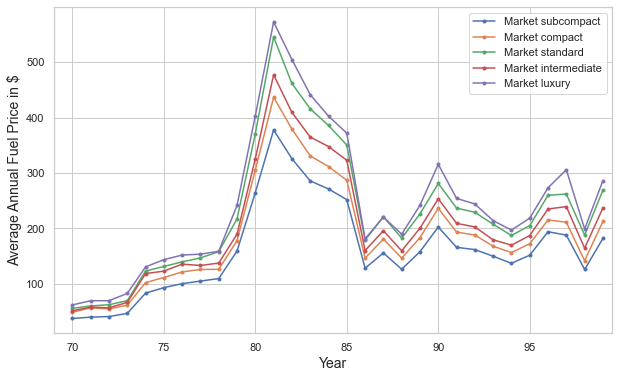

In [8]:
class_order = ['subcompact','compact', 'standard', 'intermediate', 'luxury']
# Plots
cars_grouped = cars.groupby(['ye', 'class']).agg({'Fuel_price_ann_dollar': 'mean'}).reset_index()

# Pivot the data for plotting
cars_pivoted = cars_grouped.pivot(index='ye', columns='class', values='Fuel_price_ann_dollar')
cars_pivoted = cars_pivoted[class_order]

# Plotting the data
plt.figure(figsize=(10, 6))

# Plotting each market as a separate line
for column in cars_pivoted.columns:
    plt.plot(cars_pivoted.index, cars_pivoted[column], marker='.', label=f'Market {column}')

#plt.title('Average Annual Fuel Price in Dollars by Class Over Time', fontsize=16,weight='bold')
plt.xlabel('Year', fontsize=14)
plt.xlim(69, 99.5)
plt.ylabel('Average Annual Fuel Price in $', fontsize=14)
plt.legend()
plt.grid(True)

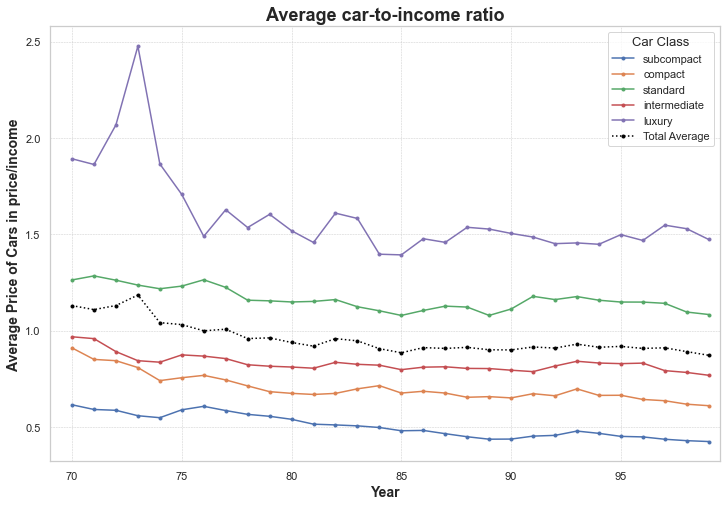

In [9]:
import matplotlib.pyplot as plt

# Assuming `cars` DataFrame and `class_order` are already defined

# Group and pivot the data
cars_grouped = cars.groupby(['ye', 'class']).agg({'princ': 'mean'}).reset_index()
cars_pivoted = cars_grouped.pivot(index='ye', columns='class', values='princ')
cars_pivoted = cars_pivoted[class_order]

# Calculate the total average for each year
cars_pivoted['Total Average'] = cars_pivoted.mean(axis=1)

# Plotting the data
plt.figure(figsize=(12, 8))

# Plotting each market as a separate line with dot markers
for column in cars_pivoted.columns[:-1]:  # Exclude the total average for now
    plt.plot(cars_pivoted.index, cars_pivoted[column], marker='.', linestyle='-', label=f'{column}')

# Plotting the total average as a dotted black line
plt.plot(cars_pivoted.index, cars_pivoted['Total Average'], marker='.', linestyle=':', color='black', label='Total Average')

# Update title and labels
plt.title('Average car-to-income ratio', fontsize=18, fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Average Price of Cars in price/income', fontsize=14, fontweight='bold')

# Adding legend and grid
plt.legend(title='Car Class', title_fontsize='13', fontsize='11')
plt.grid(True, linestyle='--', linewidth=0.5)

# Set x-axis limits
plt.xlim(69, 99.5)

# Show the plot
plt.show()


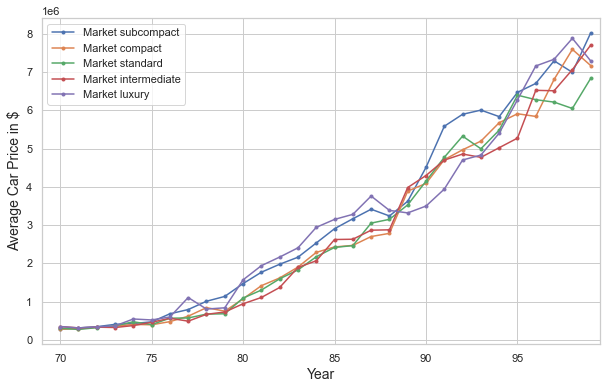

In [10]:
# Plots
cars_grouped = cars.groupby(['ye', 'class']).agg({'pr_dollar': 'mean'}).reset_index()

# Pivot the data for plotting
cars_pivoted = cars_grouped.pivot(index='ye', columns='class', values='pr_dollar')
cars_pivoted = cars_pivoted[class_order]

# Plotting the data
plt.figure(figsize=(10, 6))

# Plotting each market as a separate line
for column in cars_pivoted.columns:
    plt.plot(cars_pivoted.index, cars_pivoted[column], marker='.', label=f'Market {column}')

#plt.title('Average Car Price in Dollars by Class Over Time', fontsize=16,weight='bold')
plt.xlabel('Year', fontsize=14)
plt.xlim(69, 99.5) 
plt.ylabel('Average Car Price in $', fontsize=14)
plt.legend()
plt.grid(True)

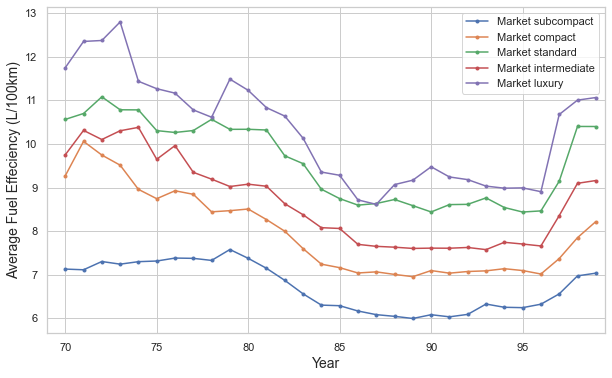

In [11]:
# Plots
cars_grouped = cars.groupby(['ye', 'class']).agg({'li': 'mean'}).reset_index()

# Pivot the data for plotting
cars_pivoted = cars_grouped.pivot(index='ye', columns='class', values='li')
cars_pivoted = cars_pivoted[class_order]

# Plotting the data
plt.figure(figsize=(10, 6))



# Plotting each market as a separate line
for column in cars_pivoted.columns:
    plt.plot(cars_pivoted.index, cars_pivoted[column], marker='.', label=f'Market {column}')

#plt.title('Average Development of Fuel Effeciency by Class Over Time', fontsize=16,weight='bold')
plt.xlabel('Year', fontsize=14)
plt.xlim(69, 99.5) 
plt.ylabel('Average Fuel Effeciency (L/100km)', fontsize=14)
plt.legend()
plt.grid(True)

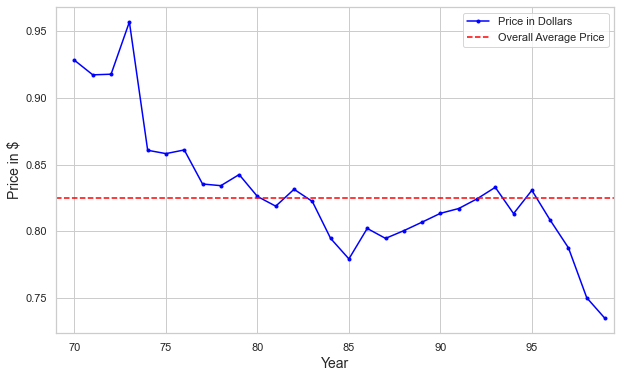

In [12]:

# Group the data by 'ye' and calculate the mean of 'princ'
grouped_data = cars.groupby('ye')['princ'].mean().reset_index()

# Calculate the overall mean of 'priceDollars'
overall_mean = cars['princ'].mean()

# Plot the data
plt.figure(figsize=(10, 6))

# Plot the average price in dollars over years
plt.plot(grouped_data['ye'], grouped_data['princ'], marker='.', color='blue', label='Price in Dollars')

# Add the overall mean line to the plot
plt.axhline(y=overall_mean, color='red', linestyle='--', label='Overall Average Price')

#plt.title('Average Price Development of one Oil Barrel Over Years', fontsize=16, weight='bold')
plt.xlabel('Year', fontsize=14)
plt.xlim(69, 99.5) 
plt.ylabel('Price in $', fontsize=14)
plt.legend()
plt.grid(True)

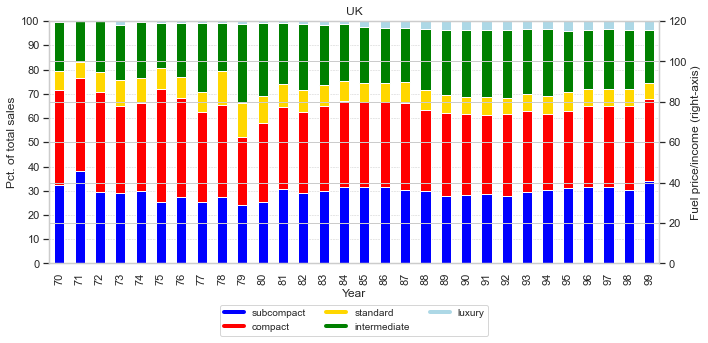

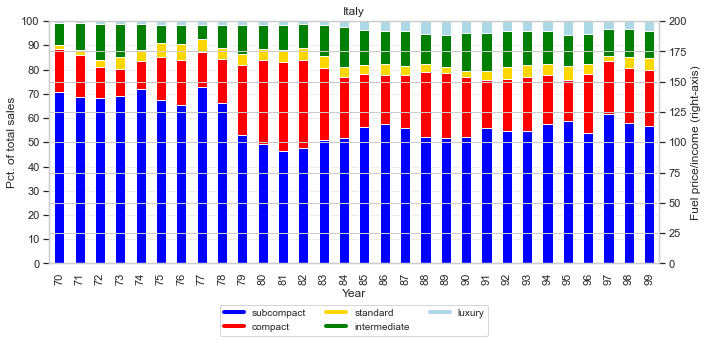

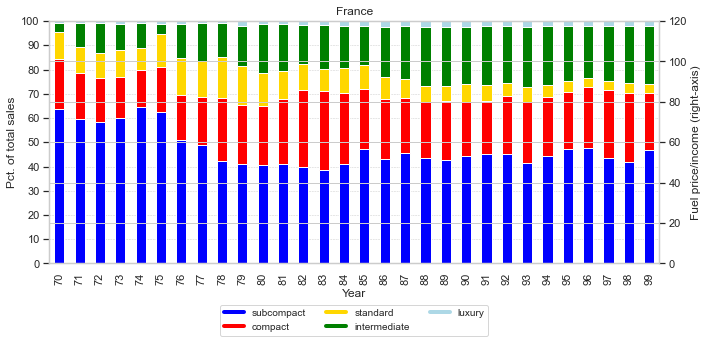

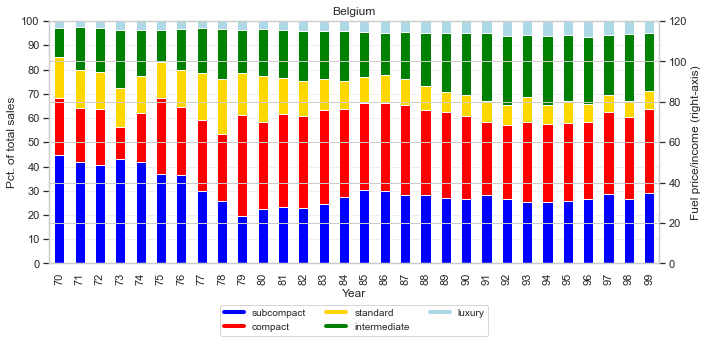

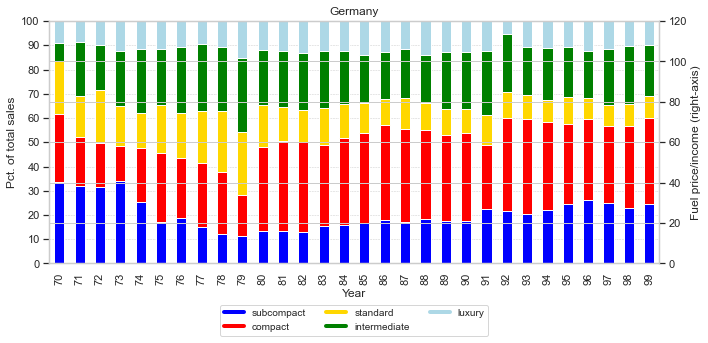

In [13]:
# Calculate share of total sales for each year, country, and class
cars['total_sales_per_year'] = cars.groupby(['ye', 'country'])['qu'].transform('sum')
cars['share_of_sales'] = (cars['qu'] / cars['total_sales_per_year']) * 100

# Ensure 'share_of_sales' is numeric
cars['share_of_sales'] = cars['share_of_sales'].astype(float)

# Aggregate data to ensure no duplicates for pivot
aggregated_data = cars.groupby(['ye', 'class', 'country']).agg({
    'share_of_sales': 'sum', 
    'Fuel_price_1L': 'mean', 
    'pr_dollar_inc': 'mean'
}).reset_index()

# Ensure 'share_of_sales' and 'Fuel_price_1L' are numeric
aggregated_data['share_of_sales'] = aggregated_data['share_of_sales'].astype(float)
aggregated_data['Fuel_price_1L'] = aggregated_data['Fuel_price_1L'].astype(float)
aggregated_data['pr_dollar_inc'] = aggregated_data['pr_dollar_inc'].astype(float)

countries = ['UK', 'Italy', 'France', 'Belgium', 'Germany']
colors = {
    'subcompact': 'blue',
    'compact': 'red',
    'standard': 'gold',
    'intermediate': 'green',
    'luxury': 'lightblue'
}

# Desired order of classes for plotting
class_order = ['subcompact', 'compact', 'standard', 'intermediate', 'luxury']

# Define specific y-axis limits for each country
y_limits = {
    'UK': (0, 120),
    'Italy': (0, 200),
    'France': (0, 120),
    'Belgium': (0, 120),
    'Germany': (0, 120)
}

for country in countries:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Filter data for the country
    country_data = aggregated_data[aggregated_data['country'] == country]
    
    # Pivot data for plotting and ensure the columns are in the desired order
    cars_pivoted = country_data.pivot(index='ye', columns='class', values='share_of_sales').reindex(columns=class_order)
    
    # Plot stacked bar chart for share of sales
    cars_pivoted.plot(kind='bar', stacked=True, ax=ax, color=[colors[col] for col in cars_pivoted.columns])
    
    # Plot fuel price/income on secondary y-axis
    fuel_price_income = country_data.groupby('ye')['Fuel_price_1L'].mean()
    princ = country_data.groupby('ye')['pr_dollar_inc'].mean()
    
    ax2 = ax.twinx()
    ax2.plot(fuel_price_income.index, fuel_price_income.values, linestyle=':', color='black', marker='o', label='Fuel price/income (right-axis)')
    ax2.set_ylabel('Fuel price/income (right-axis)')
    ax2.set_ylim(y_limits[country])
    
    ax.set_title(country)
    ax.set_xlabel('Year')
    ax.set_ylabel('Pct. of total sales')
    ax.set_ylim(0, 100)
    ax.set_yticks(range(0, 101, 10))
    ax.grid(True, linestyle='--', linewidth=0.5)
    
    # Rotate x-axis labels to vertical and adjust alignment
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
    
    # Show year for each data point
    for j, txt in enumerate(fuel_price_income.index):
        ax2.annotate(txt, (fuel_price_income.index[j], fuel_price_income.values[j]), textcoords="offset points", xytext=(0,10), ha='center')

    # Add a legend for the classes and fuel price/income
    class_handles = [plt.Line2D([0], [0], color=colors[col], lw=4) for col in class_order]
    class_labels = class_order + ['Fuel price/income (right-axis)']
    ax.legend(class_handles, class_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)
    
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.show()


In [14]:
print(cars.columns)

Index(['ye', 'ma', 'co', 'zcode', 'brd', 'type', 'brand', 'model', 'org',
       'loc', 'cla', 'home', 'frm', 'qu', 'cy', 'hp', 'we', 'pl', 'do', 'le',
       'wi', 'he', 'li1', 'li2', 'li3', 'li', 'sp', 'ac', 'pr', 'princ',
       'eurpr', 'exppr', 'avexr', 'avdexr', 'avcpr', 'avppr', 'avdcpr',
       'avdppr', 'xexr', 'tax', 'pop', 'ngdp', 'rgdp', 'engdp', 'ergdp',
       'engdpc', 'ergdpc', 'country', 'qu_total', 's', 'log_s', 'class',
       'ann_km', 'Year', 'priceDollars', 'Fuel_price_1L',
       'Fuel_price_ann_dollar', 'pr_dollar', 'pr_dollar_inc',
       'total_sales_per_year', 'share_of_sales'],
      dtype='object')


**Mangler for figuren**

- Year for hvert år
- Dottet line for "Fuel price/inc (right axis)
- Y-aksen for alle lande kan ikke ses

# Using regplot for a Single Scatterplot with Regression Line


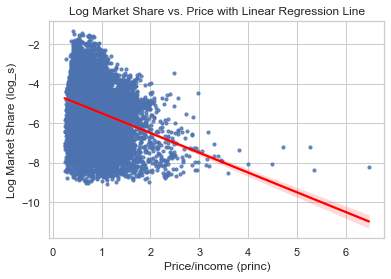

In [15]:
#regplot is a seaborn function for plotting a regression line for two variables along with a scatterplot. 
#It is a simpler function that is good for quick, straightforward plots.

# Use seaborn's regplot to create a scatterplot of 'pr' vs. 'log_s'.
# 'x' specifies the data for the x-axis (Price in this case).
# 'y' specifies the data for the y-axis (Log Market Share in this case).

sns.regplot(x='princ', y='log_s', data=cars, scatter_kws={'s': 10}, line_kws={'color': 'red'})

# Set the title of the plot with plt.title.
plt.title('Log Market Share vs. Price with Linear Regression Line')

# Set the label for the x-axis with plt.xlabel.
plt.xlabel('Price/income (princ)')

# Set the label for the y-axis with plt.ylabel.
plt.ylabel('Log Market Share (log_s)')

# Display the plot with plt.show().
plt.show()

In [16]:
#### Replace 'pr', 'hp' etc., with the actual attribute names you want to include
cars['princ'] = pd.to_numeric(cars['princ'], errors='coerce')
# Convert additional attributes as needed

# Replace any infinite values with NaN and then drop rows with NaN values in these columns
cars.replace([np.inf, -np.inf], np.nan, inplace=True)
cars.dropna(subset=['princ'], inplace=True)  #

# Prepare your independent variables DataFrame including the constant and other variables
X = cars[['princ']]  # I can add more attributes if it is needed
X = sm.add_constant(X)

# Define your dependent variable
y = cars['log_s']

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the summary of your regression model
print(model.summary())

print(cars.shape)


                            OLS Regression Results                            
Dep. Variable:                  log_s   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     937.2
Date:                Mon, 10 Jun 2024   Prob (F-statistic):          5.85e-198
Time:                        06:12:41   Log-Likelihood:                -20599.
No. Observations:               11549   AIC:                         4.120e+04
Df Residuals:                   11547   BIC:                         4.122e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4855      0.030   -148.674      0.0

# Integrate this into the regression setup - Only with prices

# Integrate this into the regression setup

**Svar på disse tal**

- As princ increases, log_s decreases. This makes intuitive sense, as higher prices relative to income would likely reduce the market share

- R-squared: 0.078, indicating that only 7.8% of the variation in log_s is explained by princ. This low R-squared suggests other factors are also important.

Conclusion:
This result shows a negative relationship between price/income and market share, but we must be cautious because the error term might be correlated with the endogenous variable (princ), leading to biased estimates.

In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Liste over attributter
attributes = ['princ', 'we', 'ac', 'hp', 'le']

# Assuming 'class' is the name of the categorical variable you want to include as fixed effects
# Create dummy variables for the 'class' column
cars = pd.get_dummies(cars, columns=['class'], drop_first=True)

# Sørg for, at alle relevante kolonner er renset for NaN og uendelige værdier
cars[attributes] = cars[attributes].replace([np.inf, -np.inf], np.nan)
cars.dropna(subset=attributes, inplace=True)

# List of columns including attributes and class dummies
class_dummies = [col for col in cars.columns if col.startswith('class_')]
all_vars = attributes + class_dummies

# Loop gennem hver attribut og kør regression kun med 'princ' og den pågældende attribut
for attr in attributes:
    if attr != 'princ':  # Undgå dobbelt optælling af 'princ'
        X_attr = sm.add_constant(cars[[attr, 'princ'] + class_dummies])  # Tilføj 'princ', den aktuelle attribut og class dummies
        model_attr = sm.OLS(cars['log_s'], X_attr).fit()
        print(f"Regression med pris og {attr}:")
        print(model_attr.summary())
        print("\n")
    else:  # Hvis attributen er 'princ', inkluder 'princ' og class dummies
        X_price = sm.add_constant(cars[['princ'] + class_dummies])
        model_price = sm.OLS(cars['log_s'], X_price).fit()
        print("Regression kun med pris:")
        print(model_price.summary())
        print("\n")

# Til sidst kør en regression med alle attributter og class dummies inkluderet
X_all = sm.add_constant(cars[all_vars])
model_all = sm.OLS(cars['log_s'], X_all).fit()
print("Regression med alle attributter og class dummies:")
print(model_all.summary())


Regression kun med pris:
                            OLS Regression Results                            
Dep. Variable:                  log_s   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     186.1
Date:                Mon, 10 Jun 2024   Prob (F-statistic):          2.19e-189
Time:                        06:12:41   Log-Likelihood:                -16471.
No. Observations:                9232   AIC:                         3.295e+04
Df Residuals:                    9226   BIC:                         3.300e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

- Køre regressionerne country by country => se om princ ryger på minus
- Det er horsepower som påvirker princ - den går fra negativ til positiv, hvilket ikke burde være rigtigt
- Lave om på estimater
- Understreger endogenitetsproblemet => princ

- **Spørgsmål**:
    - ac har en positiv effekt og ikke hp??

# Brand-dummies and the coefficients calues

## **GETTING VALUES FOR ATTRIBUTES WITH DUMMIES EFFECT. ALSO AVERAGE ELASTICITIES AND MARKET SHARE FOR EACH BRAND**

In [18]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Ensure consistent column name cleaning
def clean_column_names(df):
    df.columns = [col.replace(' ', '_').replace('/', '_').replace('-', '_') for col in df.columns]
    return df

# Clean column names in the DataFrame
cars = clean_column_names(cars)

# Function to create dummy variables and perform OLS regression
def estimate_ols_with_dummies(cars):
    # Create dummy variables for specified columns
    dummy_columns = ['brand', 'type', 'ye', 'country']
    cars = create_dummies(cars, dummy_columns)
    
    # Select predictors
    predictors = ['princ', 'hp', 'ac', 'we', 'le']
    dummy_cols = cars.columns[cars.columns.str.startswith(('brand_', 'type_', 'ye_', 'country_'))]
    
    X = cars[predictors + list(dummy_cols)]
    
    # Add constant term
    X = sm.add_constant(X)
    
    # Dependent variable
    y = cars['log_s']
    
    # Perform OLS regression
    ols_model = sm.OLS(y, X).fit()
    return ols_model

# Function to check and create dummy variables for specified columns if they exist
def create_dummies(df, columns):
    for column in columns:
        if column in df.columns:
            # Create dummies without dropping any category
            df = pd.get_dummies(df, columns=[column], drop_first=False)
    return df

# Perform OLS regression with dummies
ols_model = estimate_ols_with_dummies(cars)
print("OLS Regression with Brand, Type, Year, and Country Dummies Summary:")
print(ols_model.summary())


OLS Regression with Brand, Type, Year, and Country Dummies Summary:
                            OLS Regression Results                            
Dep. Variable:                  log_s   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     27.17
Date:                Mon, 10 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:12:42   Log-Likelihood:                -13346.
No. Observations:                9232   AIC:                         2.745e+04
Df Residuals:                    8851   BIC:                         3.017e+04
Df Model:                         380                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

# Fixed Effects for Brand-dummies on the attributes and classes

In [19]:
# Print the unique values in the 'cla' column
print("Unique values in 'cla' column:")
print(cars['cla'].unique())

# Print the value counts of the 'cla' column
print("\nValue counts of 'cla' column:")
print(cars['cla'].value_counts())

# Print the first few rows of the 'cla' column
print("\nFirst few rows of the 'cla' column:")
print(cars['cla'].head())

# Create dummy variables for the 'cla' column and show their representation
cla_dummies = pd.get_dummies(cars['cla'], prefix='cla', drop_first=False)
print("\nDummy variables for 'cla' column:")
print(cla_dummies.head())

# Print what each dummy variable represents
print("\nRepresentation of 'cla' dummy variables:")
for column in cla_dummies.columns:
    print(f"{column}: Represents the class '{column.split('_')[1]}'")


Unique values in 'cla' column:
[2 3 5 4 1]

Value counts of 'cla' column:
1    2489
2    2166
3    2013
4    1676
5     888
Name: cla, dtype: int64

First few rows of the 'cla' column:
1    2
2    2
3    2
4    2
5    2
Name: cla, dtype: int64

Dummy variables for 'cla' column:
   cla_1  cla_2  cla_3  cla_4  cla_5
1      0      1      0      0      0
2      0      1      0      0      0
3      0      1      0      0      0
4      0      1      0      0      0
5      0      1      0      0      0

Representation of 'cla' dummy variables:
cla_1: Represents the class '1'
cla_2: Represents the class '2'
cla_3: Represents the class '3'
cla_4: Represents the class '4'
cla_5: Represents the class '5'


In [20]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Ensure consistent column name cleaning
def clean_column_names(df):
    df.columns = [col.replace(' ', '_').replace('/', '_').replace('-', '_') for col in df.columns]
    return df

# Clean column names in the DataFrame
cars = clean_column_names(cars)

# Function to create dummy variables and perform OLS regression
def estimate_ols_with_dummies(cars):
    # Create dummy variables for specified columns
    dummy_columns = ['brand','cla']
    cars = create_dummies(cars, dummy_columns)
    
    # Select predictors
    predictors = ['princ', 'hp', 'we', 'li', 'Fuel_price_ann_dollar'] 
    dummy_cols = cars.columns[cars.columns.str.startswith(('brand_', 'cla_'))]

    X = cars[predictors + list(dummy_cols)]
    
    # Add constant term
    X = sm.add_constant(X)
    
    # Dependent variable
    y = cars['log_s']
    
    # Perform OLS regression
    ols_model = sm.OLS(y, X).fit()
    return ols_model

# Function to check and create dummy variables for specified columns if they exist
def create_dummies(df, columns):
    for column in columns:
        if column in df.columns:
            # Create dummies without dropping any category
            df = pd.get_dummies(df, columns=[column], drop_first=False)
    return df

# Perform OLS regression with dummies
ols_model = estimate_ols_with_dummies(cars)
print("OLS Regression with Brand Dummies Summary:")
print(ols_model.summary())


OLS Regression with Brand Dummies Summary:
                            OLS Regression Results                            
Dep. Variable:                  log_s   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     123.2
Date:                Mon, 10 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:12:42   Log-Likelihood:                -14735.
No. Observations:                9232   AIC:                         2.956e+04
Df Residuals:                    9186   BIC:                         2.989e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [21]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Ensure consistent column name cleaning
def clean_column_names(df):
    df.columns = [col.replace(' ', '_').replace('/', '_').replace('-', '_') for col in df.columns]
    return df

# Clean column names in the DataFrame
cars = clean_column_names(cars)

# Function to create dummy variables and perform OLS regression
def estimate_ols_with_dummies(cars):
    # Create dummy variables for specified columns
    dummy_columns = ['brand', 'type', 'ye', 'country', 'cla']
    cars = create_dummies(cars, dummy_columns)
    
    # Select predictors
    predictors = ['princ', 'hp', 'ac', 'we', 'le']
    dummy_cols = cars.columns[cars.columns.str.startswith(('brand_', 'type_', 'ye_', 'country_', 'cla_'))]
    
    X = cars[predictors + list(dummy_cols)]
    
    # Add constant term
    X = sm.add_constant(X)
    
    # Dependent variable
    y = cars['log_s']
    
    # Perform OLS regression
    ols_model = sm.OLS(y, X).fit()
    return ols_model

# Function to check and create dummy variables for specified columns if they exist
def create_dummies(df, columns):
    for column in columns:
        if column in df.columns:
            # Create dummies without dropping any category
            df = pd.get_dummies(df, columns=[column], drop_first=False)
    return df

# Perform OLS regression with dummies
ols_model = estimate_ols_with_dummies(cars)
print("OLS Regression with Brand Dummies Summary:")
print(ols_model.summary())


OLS Regression with Brand Dummies Summary:
                            OLS Regression Results                            
Dep. Variable:                  log_s   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     27.17
Date:                Mon, 10 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:12:43   Log-Likelihood:                -13346.
No. Observations:                9232   AIC:                         2.745e+04
Df Residuals:                    8851   BIC:                         3.017e+04
Df Model:                         380                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

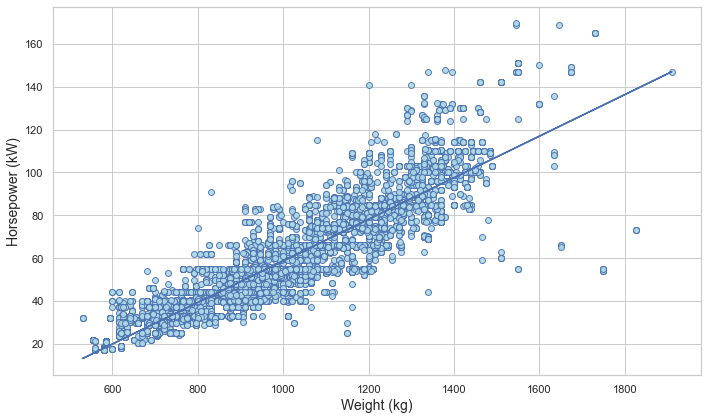

In [52]:

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

# Scatter plot for horsepower vs weight
plt.scatter(cars['we'], cars['hp'],alpha=0.9, color='lightblue', edgecolor='b')

# Adding a trend line
z = np.polyfit( cars['we'],cars['hp'], 1)
p = np.poly1d(z)
plt.plot(cars['we'], p(cars['we']), "b-")

# Labels and title
plt.ylabel('Horsepower (kW)', fontsize=14)
plt.xlabel('Weight (kg)', fontsize=14)
#plt.title('Correlation between Horsepower and Weight of Cars', fontsize=18, weight='bold')

plt.grid(True)
plt.tight_layout()


## OLS

In [22]:
import statsmodels.formula.api as smf

# Assuming cars_est is a DataFrame already defined elsewhere in the code
cars_est = cars.copy()

# Convert 'class' and 'home' to categorical variables
cars_est['cla_category'] = cars_est['cla'].astype('category')
cars_est['home_category'] = cars_est['home'].astype('category')

# Define OLS models with the specified instruments
ols_model_all = smf.ols('log_s ~ princ + li + we + hp + Fuel_price_ann_dollar + cla_category + home_category', data=cars_est).fit(cov_type='HC3')
ols_model_wo_weight = smf.ols('log_s ~ princ + le + hp + ac + Fuel_price_ann_dollar + cla_category + home_category', data=cars_est).fit(cov_type='HC3')
ols_model_all_wo_class = smf.ols('log_s ~ princ + le + we + hp + ac + Fuel_price_ann_dollar + home_category', data=cars_est).fit(cov_type='HC3')
ols_model_hp = smf.ols('log_s ~ princ + li + we + hp + Fuel_price_ann_dollar + cla_category + home_category', data=cars_est).fit(cov_type='HC3')


In [23]:
ols_model_all_results = pd.DataFrame({
    'Coefficient': ols_model_all.params,
    'Std. Error': ols_model_all.bse,
    't-value': ols_model_all.tvalues,
    'p-value': ols_model_all.pvalues,
})

ols_model_wo_weight_results = pd.DataFrame({
    'Coefficient': ols_model_wo_weight.params,
    'Std. Error': ols_model_wo_weight.bse,
    't-value': ols_model_wo_weight.tvalues,
    'p-value': ols_model_wo_weight.pvalues
})


ols_model_all_wo_class_results = pd.DataFrame({
    'Coefficient': ols_model_all_wo_class.params,
    'Std. Error': ols_model_all_wo_class.bse,
    't-value': ols_model_all_wo_class.tvalues,
    'p-value': ols_model_all_wo_class.pvalues
})

ols_model_hp_results = pd.DataFrame({
    'Coefficient': ols_model_hp.params,
    'Std. Error': ols_model_hp.bse,
    't-value': ols_model_hp.tvalues,
    'p-value': ols_model_hp.pvalues
})



# Combine the results into one DataFrame for comparison
comparison_table = pd.DataFrame({
    'OLS Coefficient (All)': ols_model_all_results['Coefficient'],
    'Std. Error Coefficient (All)': ols_model_all_results['Std. Error'],
    'OLS Coefficient (w/o we)': ols_model_wo_weight_results['Coefficient'],
    'Std. Error Coefficient (w/o we)': ols_model_wo_weight_results['Std. Error'],
    'OLS Coefficient (w/o hp)': ols_model_hp_results['Coefficient'],
    'Std. Error Coefficient (w/o hp)': ols_model_hp_results['Std. Error'],
    'OLS Coefficient (w/o cla)': ols_model_all_wo_class_results['Coefficient'],
    'Std. Error Coefficient (w/o cla)': ols_model_all_wo_class_results['Std. Error']
})
comparison_table
latex_table = comparison_table.to_latex(index=True)
#print(latex_table)
#latex_table

/var/folders/fq/jrmcw87s5bvdvtl2jq535p1m0000gn/T/ipykernel_2111/3665609611.py:44: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = comparison_table.to_latex(index=True)


In [24]:
# R squared
r_squared_all = ols_model_all.rsquared
r_squared_wo_weight = ols_model_wo_weight.rsquared
r_squared_all_wo_class = ols_model_all_wo_class.rsquared
r_squared_hp = ols_model_hp.rsquared

print('All:',r_squared_all,'wo weight:',r_squared_wo_weight,'we hp:',r_squared_hp,'wo cla:',r_squared_all_wo_class)

All: 0.40332835830207325 wo weight: 0.398447839278132 we hp: 0.40332835830207325 wo cla: 0.3916131181680619


In [25]:
# Combine the results into one DataFrame for comparison including p-values
comparison_table = pd.DataFrame({
    'OLS Coefficient (All)': ols_model_all_results['Coefficient'],
    'Std. Error (All)': ols_model_all_results['Std. Error'],
    'p-value (All)': ols_model_all_results['p-value'],
    'OLS Coefficient (w/o we)': ols_model_wo_weight_results['Coefficient'],
    'Std. Error (w/o we)': ols_model_wo_weight_results['Std. Error'],
    'p-value (w/o we)': ols_model_wo_weight_results['p-value'],
    'OLS Coefficient (w/o hp)': ols_model_hp_results['Coefficient'],
    'Std. Error (w/o hp)': ols_model_hp_results['Std. Error'],
    'p-value (w/o hp)': ols_model_hp_results['p-value'],
    'OLS Coefficient (w/o cla)': ols_model_all_wo_class_results['Coefficient'],
    'Std. Error (w/o cla)': ols_model_all_wo_class_results['Std. Error'],
    'p-value (w/o cla)': ols_model_all_wo_class_results['p-value']
})

comparison_table


,OLS Coefficient (All),Std. Error (All),p-value (All),OLS Coefficient (w/o we),Std. Error (w/o we),p-value (w/o we),OLS Coefficient (w/o hp),Std. Error (w/o hp),p-value (w/o hp),OLS Coefficient (w/o cla),Std. Error (w/o cla),p-value (w/o cla)
Fuel_price_ann_dollar,-0.0004,0.0001,0.0010,-0.0004,0.0001,0.0009,-0.0004,0.0001,0.0010,-0.0004,0.0001,0.0025
Intercept,-4.7636,0.1113,0.0000,-6.8068,0.2770,0.0000,-4.7636,0.1113,0.0000,-6.5317,0.2033,0.0000
ac,NaN,NaN,NaN,-0.0149,0.0038,0.0001,NaN,NaN,NaN,-0.0166,0.0037,0.0000
cla_category[T.2],0.4986,0.0410,0.0000,0.2404,0.0492,0.0000,0.4986,0.0410,0.0000,NaN,NaN,NaN
cla_category[T.3],0.4779,0.0494,0.0000,0.1125,0.0642,0.0795,0.4779,0.0494,0.0000,NaN,NaN,NaN
cla_category[T.4],0.3695,0.0681,0.0000,0.0399,0.0838,0.6335,0.3695,0.0681,0.0000,NaN,NaN,NaN
cla_category[T.5],0.9185,0.0852,0.0000,0.6790,0.0969,0.0000,0.9185,0.0852,0.0000,NaN,NaN,NaN
home_category[T.1],1.6505,0.0281,0.0000,1.6578,0.0283,0.0000,1.6505,0.0281,0.0000,1.6448,0.0286,0.0000
hp,-0.0448,0.0013,0.0000,-0.0397,0.0012,0.0000,-0.0448,0.0013,0.0000,-0.0453,0.0014,0.0000
le,NaN,NaN,NaN,0.0094,0.0007,0.0000,NaN,NaN,NaN,0.0062,0.0006,0.0000


In [26]:
comparison_table_p = pd.DataFrame({
    'OLS Coefficient (All)': ols_model_all_results['Coefficient'],
    'Std. Error Coefficient (All)': ols_model_all_results['p-value'],
    'OLS Coefficient (w/o we)': ols_model_wo_weight_results['Coefficient'],
    'Std. Error Coefficient (w/o we)': ols_model_wo_weight_results['p-value'],
    'OLS Coefficient (w/o hp)': ols_model_hp_results['Coefficient'],
    'Std. Error Coefficient (w/o hp)': ols_model_hp_results['p-value'],
    'OLS Coefficient (w/o cla)': ols_model_all_wo_class_results['Coefficient'],
    'Std. Error Coefficient (w/o cla)': ols_model_all_wo_class_results['p-value']
})
comparison_table_p


,OLS Coefficient (All),Std. Error Coefficient (All),OLS Coefficient (w/o we),Std. Error Coefficient (w/o we),OLS Coefficient (w/o hp),Std. Error Coefficient (w/o hp),OLS Coefficient (w/o cla),Std. Error Coefficient (w/o cla)
Fuel_price_ann_dollar,-0.0004,0.0010,-0.0004,0.0009,-0.0004,0.0010,-0.0004,0.0025
Intercept,-4.7636,0.0000,-6.8068,0.0000,-4.7636,0.0000,-6.5317,0.0000
ac,NaN,NaN,-0.0149,0.0001,NaN,NaN,-0.0166,0.0000
cla_category[T.2],0.4986,0.0000,0.2404,0.0000,0.4986,0.0000,NaN,NaN
cla_category[T.3],0.4779,0.0000,0.1125,0.0795,0.4779,0.0000,NaN,NaN
cla_category[T.4],0.3695,0.0000,0.0399,0.6335,0.3695,0.0000,NaN,NaN
cla_category[T.5],0.9185,0.0000,0.6790,0.0000,0.9185,0.0000,NaN,NaN
home_category[T.1],1.6505,0.0000,1.6578,0.0000,1.6505,0.0000,1.6448,0.0000
hp,-0.0448,0.0000,-0.0397,0.0000,-0.0448,0.0000,-0.0453,0.0000
le,NaN,NaN,0.0094,0.0000,NaN,NaN,0.0062,0.0000


In [27]:
import statsmodels.formula.api as smf

# Assuming cars_est is a DataFrame already defined elsewhere in the code
cars_est = cars.copy()

# Convert 'class' and 'home' to categorical variables
cars_est['cla_category'] = cars_est['cla'].astype('category')
cars_est['home_category'] = cars_est['home'].astype('category')

# Define the OLS model without the class variable and with the specified instruments
ols_model = smf.ols('log_s ~ princ + hp + we + li + Fuel_price_ann_dollar + cla_category + home_category', data=cars_est).fit(cov_type='HC3')
ols_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  log_s   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     807.4
Date:                Mon, 10 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:12:43   Log-Likelihood:                -14531.
No. Observations:                9232   AIC:                         2.908e+04
Df Residuals:                    9221   BIC:                         2.916e+04
Df Model:                          10                                         
Covariance Type:                  HC3                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -4.7636      0.111    -42.795      0.000      -4.982      -4.545
cla_category[T.2]         0.4986      0.041     12.167      0.000       0.418       0.579
cla_category[T.3]         0.4779      0.049      9.675      0.000       0.381       0.575
cla_category[T.4]         0.3695      0.068      5.424      0.000       0.236       0.503
cla_category[T.5]         0.9185      0.085     10.781      0.000       0.751       1.085
home_category[T.1]        1.6505      0.028     58.655      0.000       1.595       1.706
princ                    -0.0976      0.050     -1.944      0.052      -0.196       0.001
hp                       -0.0448      0.001    -34.733      0.000      -0.047      -0.042
we                        0.0025      0.000     15.155      0.000       0.002       0.003
li                       -0.1053      0.011     -9.179      0.000      -0.128      -0.083
Fuel_price_ann_dollar    -0.0004      0.000     -3.278      0.001      -0.001      -0.000
==============================================================================
Omnibus:                      325.309   Durbin-Watson:                   0.484
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              358.119
Skew:                          -0.478   Prob(JB):                     1.72e-78
Kurtosis:                       2.870   Cond. No.                     1.20e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 2SLS

In [28]:
# Data preparation and cleaning functions
def clean_column_names(df):
    df.columns = [col.replace(' ', '_').replace('/', '_').replace('-', '_') for col in df.columns]
    return df

def ensure_unique_columns(df):
    cols = pd.Series(df.columns)
    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
    df.columns = cols
    return df

# Clean column names and ensure uniqueness
cars = clean_column_names(cars)
cars = ensure_unique_columns(cars)

# Ensure 'z' exists as an instrument
if 'z' not in cars.columns:
    np.random.seed(0)  # For reproducibility
    cars['z'] = np.random.randn(len(cars))

# Fill missing values in 'z'
cars['z'].fillna(cars['z'].mean(), inplace=True)

# Define attributes and create their sum as instruments
attributes = ['hp', 'ac', 'we', 'le']
for attr in attributes:
    cars[f'{attr}_sum'] = cars.groupby(['cla', 'Year', 'country'])[attr].transform('sum') - cars[attr]

# Create dummy variables for class, dropping the first to avoid multicollinearity
class_dummies = pd.get_dummies(cars['cla'], prefix='class', drop_first=True)
cars = pd.concat([cars, class_dummies], axis=1)

# Ensure unique column names in the dataframe
cars = ensure_unique_columns(cars)

# First Stage Regression: 'z' is the instrument for 'princ'
first_stage_formula = f"princ ~ le_sum + hp_sum + we_sum + ac_sum + z + {' + '.join(class_dummies.columns)}"
first_stage = smf.ols(formula=first_stage_formula, data=cars).fit(cov_type='HC3')
print("First Stage Regression Summary:")
print(first_stage.summary())
print("\n")


First Stage Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                  princ   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     1522.
Date:                Mon, 10 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:12:43   Log-Likelihood:                -569.04
No. Observations:                9232   AIC:                             1158.
Df Residuals:                    9222   BIC:                             1229.
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.652

## Fixed effects

In [29]:
print(cars.columns)

Index(['ye', 'ma', 'co', 'zcode', 'brd', 'type', 'brand', 'model', 'org',
       'loc', 'cla', 'home', 'frm', 'qu', 'cy', 'hp', 'we', 'pl', 'do', 'le',
       'wi', 'he', 'li1', 'li2', 'li3', 'li', 'sp', 'ac', 'pr', 'princ',
       'eurpr', 'exppr', 'avexr', 'avdexr', 'avcpr', 'avppr', 'avdcpr',
       'avdppr', 'xexr', 'tax', 'pop', 'ngdp', 'rgdp', 'engdp', 'ergdp',
       'engdpc', 'ergdpc', 'country', 'qu_total', 's', 'log_s', 'ann_km',
       'Year', 'priceDollars', 'Fuel_price_1L', 'Fuel_price_ann_dollar',
       'pr_dollar', 'pr_dollar_inc', 'total_sales_per_year', 'share_of_sales',
       'class_intermediate', 'class_luxury', 'class_standard',
       'class_subcompact', 'z', 'hp_sum', 'ac_sum', 'we_sum', 'le_sum',
       'class_2', 'class_3', 'class_4', 'class_5'],
      dtype='object')


### Annual Fuel Economy

In [30]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Ensure consistent column name cleaning
def clean_column_names(df):
    df.columns = [col.replace(' ', '_').replace('/', '_').replace('-', '_') for col in df.columns]
    return df

# Clean column names in the DataFrame
cars = clean_column_names(cars)

# Calculate annual fuel cost and scale it
cars['Fuel_price_ann_dollar'] = cars['Fuel_price_1L'] * cars['ann_km'] * (cars['li'] / 100)
cars['Fuel_price_ann_dollar_scaled'] = cars['Fuel_price_ann_dollar'] / 100  # Adjust scale if necessary

# Function to create dummy variables and perform OLS regression
def estimate_ols_with_dummies(cars, price_variable, include_fixed_effects=True):
    if include_fixed_effects:
        # Create dummy variables for specified columns
        dummy_columns = ['brand', 'type', 'ye', 'country']
        cars = create_dummies(cars, dummy_columns)
    
    # Use the specified price variable
    cars['princ'] = cars[price_variable]
    
    # Select predictors
    predictors = ['princ', 'hp', 'ac', 'we', 'le']
    
    if include_fixed_effects:
        dummy_cols = cars.columns[cars.columns.str.startswith(('brand_', 'type_', 'ye_', 'country_'))]
        X = cars[predictors + list(dummy_cols)]
    else:
        X = cars[predictors]
    
    # Add constant term
    X = sm.add_constant(X)
    
    # Dependent variable
    y = cars['log_s']
    
    # Perform OLS regression
    ols_model = sm.OLS(y, X).fit()
    return ols_model

# Function to check and create dummy variables for specified columns if they exist
def create_dummies(df, columns):
    for column in columns:
        if column in df.columns:
            # Create dummies without dropping any category
            df = pd.get_dummies(df, columns=[column], drop_first=False)
    return df

# Perform OLS regression without fixed effects using scaled annual fuel cost as the price variable
ols_model_ann_no_fixed = estimate_ols_with_dummies(cars, 'Fuel_price_ann_dollar_scaled', include_fixed_effects=False)
print("OLS Regression without Fixed Effects using Scaled Annual Fuel Cost as Price Variable Summary:")
print(ols_model_ann_no_fixed.summary())

# Perform OLS regression with fixed effects using scaled annual fuel cost as the price variable
ols_model_ann_with_fixed = estimate_ols_with_dummies(cars, 'Fuel_price_ann_dollar_scaled', include_fixed_effects=True)
print("OLS Regression with Fixed Effects using Scaled Annual Fuel Cost as Price Variable Summary:")
print(ols_model_ann_with_fixed.summary())

OLS Regression without Fixed Effects using Scaled Annual Fuel Cost as Price Variable Summary:
                            OLS Regression Results                            
Dep. Variable:                  log_s   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     468.5
Date:                Mon, 10 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:12:44   Log-Likelihood:                -15870.
No. Observations:                9232   AIC:                         3.175e+04
Df Residuals:                    9226   BIC:                         3.180e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

### Fuel economy

- **Multicollinearity**: Including all dummy variables can cause multicollinearity because the sum of the dummies for each category will equal 1. This is usually handled by dropping one category to serve as the reference.
- **Interpretation**: The coefficients for the dummy variables should be interpreted relative to the dropped category. If you include all categories, the intercept acts as the reference level for all categories.

# IV-regression

# Instrumenter for 'hp', 'ac', 'le', 'we'

### IV Without Classes:

In [31]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

# Assuming 'cars' DataFrame is already loaded and processed

# List of attributes
attributes = ['hp', 'ac', 'we', 'le']

# Calculate the sum of each attribute as a potential instrument, excluding the current observation
for attr in attributes:
    cars[f'{attr}_sum'] = cars.groupby(['cla', 'ye', 'country'])[attr].transform('sum') - cars[attr]

# First stage regression formula
exog_first_stage = ' + '.join([f'{attr}_sum' for attr in attributes])
first_stage_formula = f'princ ~ {exog_first_stage}'

# Perform the first stage regression
first_stage = smf.ols(first_stage_formula, data=cars).fit()
cars['princ_fitted'] = first_stage.fittedvalues  # First stage predicted values

# Add an intercept for the second stage regression if not already present
if 'Intercept' not in cars.columns:
    cars['Intercept'] = 1.0

# Exogenous variables for the second stage regression
exog_vars = ['Intercept'] + attributes  # Original attributes with intercept

# Instruments for the second stage regression
instruments = [f'{attr}_sum' for attr in attributes]  # Sums of the attributes

# Second stage regression using IV2SLS
second_stage = IV2SLS(dependent=cars['log_s'],  # Dependent variable
                      exog=cars[exog_vars],  # Exogenous variables including intercept
                      endog=cars['princ'],  # Endogenous variable (original price, not fitted)
                      instruments=cars[instruments]).fit()  # Instruments

print("First Stage Regression Summary using all attributes as instruments:")
print(first_stage.summary())
print("\n")

# Summary of IV2SLS to find the effect of 'princ' on 'log_s' via princ_fitted
print("Second Stage IV Regression Summary using all attributes as instruments:")
print(second_stage.summary)
print("\n")

# OLS regression for comparison (without IV correction)
second_stage_OLS = smf.ols('log_s ~ hp + ac + we + le + princ', data=cars).fit(cov_type='HC3')
print("OLS Regression for Comparison (without IV correction):")
print(second_stage_OLS.summary())
print("\n")


First Stage Regression Summary using all attributes as instruments:
                            OLS Regression Results                            
Dep. Variable:                  princ   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     117.0
Date:                Mon, 10 Jun 2024   Prob (F-statistic):           1.66e-97
Time:                        06:12:45   Log-Likelihood:                -12660.
No. Observations:                9232   AIC:                         2.533e+04
Df Residuals:                    9227   BIC:                         2.537e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

In [32]:
print(cars.columns)


Index(['ye', 'ma', 'co', 'zcode', 'brd', 'type', 'brand', 'model', 'org',
       'loc', 'cla', 'home', 'frm', 'qu', 'cy', 'hp', 'we', 'pl', 'do', 'le',
       'wi', 'he', 'li1', 'li2', 'li3', 'li', 'sp', 'ac', 'pr', 'princ',
       'eurpr', 'exppr', 'avexr', 'avdexr', 'avcpr', 'avppr', 'avdcpr',
       'avdppr', 'xexr', 'tax', 'pop', 'ngdp', 'rgdp', 'engdp', 'ergdp',
       'engdpc', 'ergdpc', 'country', 'qu_total', 's', 'log_s', 'ann_km',
       'Year', 'priceDollars', 'Fuel_price_1L', 'Fuel_price_ann_dollar',
       'pr_dollar', 'pr_dollar_inc', 'total_sales_per_year', 'share_of_sales',
       'class_intermediate', 'class_luxury', 'class_standard',
       'class_subcompact', 'z', 'hp_sum', 'ac_sum', 'we_sum', 'le_sum',
       'class_2', 'class_3', 'class_4', 'class_5',
       'Fuel_price_ann_dollar_scaled', 'princ_fitted', 'Intercept'],
      dtype='object')


Prædikterede pris

**First stage er t-stat signifikante

Litteratur for hvorfor BLP instrumentet er dårligt

Prøve med nye instrumenter/et givet land/Måske involvere country fixed effects

Unobserved effects er tidskonstant (xi)

- **Weak Instruments**: If the instruments are weak (i.e., they do not strongly predict the endogenous variable princ), the IV estimates can be biased and inconsistent, potentially resulting in counterintuitive coefficients.
- **Multicollinearity**: High multicollinearity among the instruments and exogenous variables can affect the stability and reliability of the coefficient estimates.
- **Specification Issues**: Incorrect model specification, including omitted variable bias or incorrect functional form, can lead to misleading results.

Estimeret med OLS, engogenitetsproblen, Instrument BLP foreslår man bruger

**COMMENT ON IF THEY ARE GOOD INSTRUMENTS BASED ON IF THEY ARE STRONGLY CORRELATED WITH THE PRICE**

**REMEMBER, BLP INSTRUMENT IS CRITISED FOR BEING WEAK - INCLUDE IN DISKUSSION WITH FINDING LITTERATURE FOR THIS**

**Svage instrumenter kan føre til biased og ineffektive estiamter (Paper for Gandi instrumenter)**

# IV With Classes:

**First Stage and Second Stage**

In [33]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

# Function to clean column names
def clean_column_names(df):
    df.columns = [col.replace(' ', '_').replace('/', '_').replace('-', '_') for col in df.columns]
    return df

# Ensure unique column names by appending a suffix if duplicates are found
def ensure_unique_columns(df):
    cols = pd.Series(df.columns)
    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
    df.columns = cols
    return df

# Assuming cars is already defined and loaded
cars = clean_column_names(cars)

# List of attributes
attributes = ['hp', 'ac', 'we', 'le']

# Ensure the 'z' variable exists; if not, create a dummy variable for the sake of illustration
if 'z' not in cars.columns:
    np.random.seed(0)  # For reproducibility
    cars['z'] = np.random.randn(len(cars))

# Check for missing values in 'z'
if cars['z'].isnull().any():
    cars['z'].fillna(cars['z'].mean(), inplace=True)

# Calculate the sum of each attribute as a potential instrument, excluding the current observation
for attr in attributes:
    cars[f'{attr}_sum'] = cars.groupby(['cla', 'ye', 'country'])[attr].transform('sum') - cars[attr]

# Create dummy variables for class, dropping the first to avoid multicollinearity
class_dummies = pd.get_dummies(cars['cla'], prefix='class', drop_first=True)
cars = pd.concat([cars, class_dummies], axis=1)

# Ensure unique column names in the dataframe
cars = ensure_unique_columns(cars)

# First stage regression formula including class dummies and 'z'
exog_first_stage = ' + '.join([f'{attr}_sum' for attr in attributes]) + ' + ' + ' + '.join(class_dummies.columns) + ' + z'
first_stage_formula = f'princ ~ {exog_first_stage}'

# Perform the first stage regression
first_stage = smf.ols(first_stage_formula, data=cars).fit()
cars['princ_fitted'] = first_stage.fittedvalues  # First stage predicted values

print("First Stage Regression Summary using all attributes and class as instruments:")
print(first_stage.summary())
print("\n")

# Add an intercept for the second stage regression if not already present
if 'Intercept' not in cars.columns:
    cars['Intercept'] = 1.0

# Exogenous variables for the second stage regression
exog_vars = ['Intercept'] + attributes + list(class_dummies.columns)  # Original attributes with intercept and class dummies

# Instruments for the second stage regression
instruments = [f'{attr}_sum' for attr in attributes] + list(class_dummies.columns) + ['z']  # Sums of the attributes and class dummies including 'z'

# Check for multicollinearity among instruments and exogenous variables
corr_matrix = cars[instruments + exog_vars].corr()
print("Correlation Matrix for Instruments and Exogenous Variables:")
print(corr_matrix)
print("\n")

# Removing highly correlated instruments if necessary
high_corr_threshold = 0.95
to_remove = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > high_corr_threshold:
            to_remove.add(corr_matrix.columns[i])

instruments = [inst for inst in instruments if inst not in to_remove]

# Ensure unique column names in exog_vars and instruments
cars = ensure_unique_columns(cars)

# Second stage regression using IV2SLS with adjusted instruments
try:
    second_stage = IV2SLS(dependent=cars['log_s'],  # Dependent variable
                          exog=cars[exog_vars],  # Exogenous variables including intercept and class
                          endog=cars['princ'],  # Endogenous variable (original price)
                          instruments=cars[instruments]).fit()  # Instruments
    print("Second Stage IV Regression Summary using adjusted instruments:")
    print(second_stage.summary)
    print("\n")
except ValueError as e:
    print(f"Error in second stage regression: {e}")

# Print the coefficient of princ from the second stage regression
print("Coefficient of 'princ' from Second Stage IV Regression:")
print(second_stage.params['princ'])
print("\n")

# OLS regression for comparison (without IV correction)
try:
    second_stage_OLS = smf.ols('log_s ~ hp + ac + we + le + princ + ' + ' + '.join(class_dummies.columns), data=cars).fit(cov_type='HC3')
    print("OLS Regression for Comparison (without IV correction):")
    print(second_stage_OLS.summary())
    print("\n")
except ValueError as e:
    print(f"Error in OLS regression: {e}")

# Print the coefficient of princ from the OLS regression
print("Coefficient of 'princ' from OLS Regression:")
print(second_stage_OLS.params['princ'])
print("\n")


First Stage Regression Summary using all attributes and class as instruments:
                            OLS Regression Results                            
Dep. Variable:                  princ   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     191.3
Date:                Mon, 10 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:12:45   Log-Likelihood:                -12098.
No. Observations:                9232   AIC:                         2.422e+04
Df Residuals:                    9222   BIC:                         2.429e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

In [34]:
# Assuming 'cars' DataFrame is already defined and processed as in your code

# Perform the first stage regression
first_stage_formula = f'princ ~ {exog_first_stage}'
first_stage = smf.ols(first_stage_formula, data=cars).fit()
cars['princ_fitted'] = first_stage.fittedvalues  # First stage predicted values


# Multicolinarity: **Needs to be more precise**

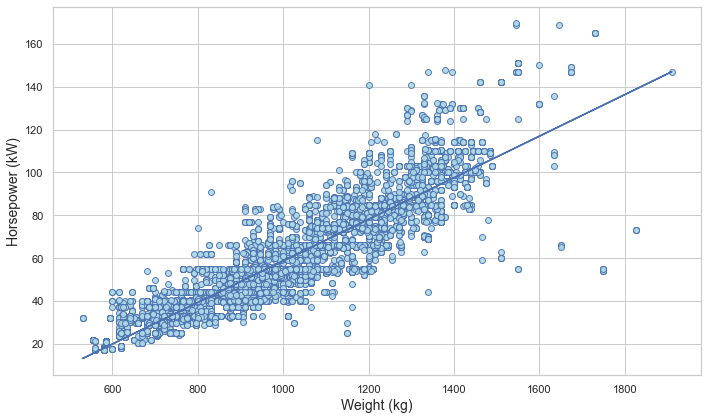

In [35]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

# Scatter plot for horsepower vs weight
plt.scatter(cars['we'], cars['hp'],alpha=0.9, color='lightblue', edgecolor='b')

# Adding a trend line
z = np.polyfit( cars['we'],cars['hp'], 1)
p = np.poly1d(z)
plt.plot(cars['we'], p(cars['we']), "b-")

# Labels and title
plt.ylabel('Horsepower (kW)', fontsize=14)
plt.xlabel('Weight (kg)', fontsize=14)
#plt.title('Correlation between Horsepower and Weight of Cars', fontsize=18, weight='bold')

plt.grid(True)
plt.tight_layout()


# Priselasticiteter


In [36]:
def utility_function(price, alpha, x, beta):
    """
    Dette er et eksempel på en nyttefunktion, hvor:
    - price er prisen på produktet
    - alpha er koefficienten for prisen
    - x er en anden attribut for produktet
    - beta er koefficienten for attributten x
    """
    return alpha * price + beta * x

def calculate_price_elasticity(price, alpha, P_ni, x=None, beta=None):
    """
    Beregner priselasticiteten for en given pris og markedsandel (P_ni).
    """
    # V_ni som alpha * price => hvis kun pris påvirker nytten direkte
    V_ni_derivative = alpha  # FOC - Den afledte af V_ni med hensyn til pris er beta_price
    z_ni = price  # Prisen for produktet
    
    # Beregn elasticiteten - formlen
    elasticity = V_ni_derivative * z_ni * (1 - P_ni)
    
    return elasticity

# Antag at hver observation har samme vægt
num_observations = len(cars)
equal_weights = pd.Series([1] * num_observations)

# Beregn vægtede gennemsnitlige markedsandele
average_market_share = (cars['s'] * equal_weights).sum() / equal_weights.sum()
#average_market_share = cars['s'].mean()

# Beregn vægtede gennemsnitlige priser
average_price = (cars['princ'] * equal_weights).sum() / equal_weights.sum()
#average_price = cars['princ'].mean()

price = cars['princ']
P_ni = cars['s'] 

alpha = -1.0026 #Coefficient from Brand-dummies fixed effects
elasticity = calculate_price_elasticity(average_price, alpha, average_market_share)
#elasticity = (alpha * weighted_price * (1 - weighted_market_share)) / weighted_market_share


print(f"Priselasticiteten for markedet/produktet er: {elasticity}")



Priselasticiteten for markedet/produktet er: -1.6099675638262878


* Hver 1% ændring i prisen, vil mængden af efterspurgt ændre sig med ca. 0.618% i den modsatte retning
* Hvor følsom efterspørgslen efter et produkt eller en service er over for ændringer i prisen på dette produkt
* Relativt uelastiske, hvilket betyder, at efterspørgslen ikke er meget følsom over for prisændringer.

## Prøver at løse Bertels vejledninger:

Hvornår skal man bruge OLS: Når prisen er eksogen, og der ikke er nogen endogenitetsproblem.

Hvornår skal man bruge Fixed Effects: Når der er uobserverede, faste effekter, der kan påvirke efterspørgslen.

Hvornår skal man bruge IV: Når prisen er endogen, og der findes gode instrumenter til rådighed.


## Average Price Elasticity for each country

In [37]:
# List of countries
countries = ['Belgium', 'France', 'Germany', 'Italy', 'UK']

# Ensure all relevant columns are clean from NaNs and infinite values
attributes = ['princ', 'hp', 'ac', 'we', 'le', 's', 'country']
cars[attributes] = cars[attributes].replace([np.inf, -np.inf], np.nan)
cars.dropna(subset=attributes, inplace=True)

# Dictionary to hold elasticities for each country
elasticities = {}

# Calculate price elasticity for each country
for country in countries:
    # Filter the dataset for the current country
    country_data = cars[cars['country'] == country]

    # Check if there is data for the current country
    if not country_data.empty:
        # Calculate weighted average market shares and prices
        num_observations = len(country_data)
        total_weight = country_data['s'].sum()
        weighted_average_price = (country_data['princ'] * country_data['s']).sum() / total_weight
        weighted_average_market_share = total_weight / num_observations

        # Calculate price elasticity for the current country
        elasticity = calculate_price_elasticity(weighted_average_price, alpha, weighted_average_market_share)
        elasticities[country] = elasticity
    else:
        print(f"Ingen data tilgængelige for {country}.")

# Print price elasticities for each country
for country, elasticity in elasticities.items():
    print(f"Priselasticiteten for {country}: {elasticity:.4f}")

    
# Vi kan ikke bruge OLS (endogenitetsproblem med pos coef.), så vi estimerer med IV eller fixed effects.
# Beregne elasticitet for IV, 
# OLS, fixed, IV => For hver skal man have 

# Herefter for fixed effects med dummies, da fejlledet er korrileret med priserne
# Fixed effects => Mindre tilbage i fejlledet som er korreleret med prisen
# Ikke fjerne det hele, potentielt overveje med IV derfor
# Gøre for fixed effects, IV eller begge dele

# Forskellige estimaster for alpha (IV, OLS, fixed effect, forskellige valg af instrumenter)
# Diskutere for hvornår det kan og ikke kan bruges
# OLS => Efterspørgsel er ren logit model, priserne er eksogene => Valid hvis pris = eksogen, er de ikke her
# Eksogen variation for at rykke op og ned, for at håndtere endogenitetsproblem
# Unobserved for fejlled, estimere for OLS => fejlledet korreleret med forklarende variable og prisen bliver endogen



Priselasticiteten for Belgium: -1.8969
Priselasticiteten for France: -1.8606
Priselasticiteten for Germany: -1.9291
Priselasticiteten for Italy: -1.7882
Priselasticiteten for UK: -1.8336


# Egenpriselasticitet

In [38]:
def calculate_own_price_elasticity(alpha, price, P_ni):
    """
    Calculate the own price elasticity for a product.
    :param alpha: Price coefficient.
    :param price: Product price.
    :param P_ni: Market share of the product.
    :return: Own price elasticity.
    """
    own_price_elasticity = alpha * price * (1 - P_ni)
    return own_price_elasticity

# Price coefficient from the OLS regression - should be negative

# Assuming 'cars' DataFrame contains the price and market share columns
price = cars['princ']  # Price of the product
P_ni = cars['s']  # Market share of the product

# Calculate the own price elasticity for each product
cars['own_price_elasticity'] = cars.apply(lambda row: calculate_own_price_elasticity(alpha, row['princ'], row['s']), axis=1)

# Display the own price elasticity for each product
print(cars[['princ', 's', 'own_price_elasticity']])

# Calculate the weighted average own price elasticity
weighted_average_elasticity = (cars['own_price_elasticity'] * cars['s']).sum() / cars['s'].sum()
print(f"Weighted Average Own Price Elasticity: {weighted_average_elasticity}")


       princ      s  own_price_elasticity
1     3.3431 0.0056               -3.3331
2     3.1119 0.0052               -3.1038
3     1.6160 0.0058               -1.6108
4     2.0320 0.0057               -2.0258
5     1.6599 0.0052               -1.6556
...      ...    ...                   ...
11544 2.2257 0.0020               -2.2269
11545 2.3896 0.0043               -2.3854
11546 1.8116 0.0092               -1.7996
11547 1.7253 0.0025               -1.7255
11548 2.3464 0.0041               -2.3429

[9232 rows x 3 columns]
Weighted Average Own Price Elasticity: -1.8038203484571251


* Efterspørgslen efter et bestemt produkt ændrer sig som følge af en ændring i prisen på netop dette produkt, mens alle andre faktorer holdes konstante
* Efterspørgslen ændrer sig for hvor meget man ændrer prisen => Alle valutaer ikke i 

## Average Own Price Elasticity for each Country 

In [39]:
# List of countries
countries = ['Belgium', 'France', 'Germany', 'Italy', 'UK']

# Ensure all relevant columns are clean from NaNs and infinite values
attributes = ['princ', 's', 'country']
cars[attributes] = cars[attributes].replace([np.inf, -np.inf], np.nan)
cars.dropna(subset=attributes, inplace=True)

# Dictionary to hold own price elasticities for each country
own_price_elasticities = {}

# Calculate own price elasticity for each country
for country in countries:
    # Filter the dataset for the current country
    country_data = cars[cars['country'] == country].copy()

    # Check if there is data for the current country
    if not country_data.empty:
        # Calculate weighted average own price elasticity for the country
        country_data['own_price_elasticity'] = country_data.apply(
            lambda row: calculate_own_price_elasticity(alpha, row['princ'], row['s']), axis=1)
        
        total_weight = country_data['s'].sum()
        weighted_average_own_price_elasticity = (country_data['own_price_elasticity'] * country_data['s']).sum() / total_weight
        own_price_elasticities[country] = weighted_average_own_price_elasticity
    else:
        print(f"No data available for {country}.")

# Print own price elasticities for each country
for country, own_elasticity in own_price_elasticities.items():
    print(f"Weighted Average Own Price Elasticity for {country}: {own_elasticity:.4f}")


Weighted Average Own Price Elasticity for Belgium: -1.8714
Weighted Average Own Price Elasticity for France: -1.8058
Weighted Average Own Price Elasticity for Germany: -1.8623
Weighted Average Own Price Elasticity for Italy: -1.7033
Weighted Average Own Price Elasticity for UK: -1.7783


In [40]:
print(cars.columns)

Index(['ye', 'ma', 'co', 'zcode', 'brd', 'type', 'brand', 'model', 'org',
       'loc', 'cla', 'home', 'frm', 'qu', 'cy', 'hp', 'we', 'pl', 'do', 'le',
       'wi', 'he', 'li1', 'li2', 'li3', 'li', 'sp', 'ac', 'pr', 'princ',
       'eurpr', 'exppr', 'avexr', 'avdexr', 'avcpr', 'avppr', 'avdcpr',
       'avdppr', 'xexr', 'tax', 'pop', 'ngdp', 'rgdp', 'engdp', 'ergdp',
       'engdpc', 'ergdpc', 'country', 'qu_total', 's', 'log_s', 'ann_km',
       'Year', 'priceDollars', 'Fuel_price_1L', 'Fuel_price_ann_dollar',
       'pr_dollar', 'pr_dollar_inc', 'total_sales_per_year', 'share_of_sales',
       'class_intermediate', 'class_luxury', 'class_standard',
       'class_subcompact', 'z', 'hp_sum', 'ac_sum', 'we_sum', 'le_sum',
       'class_2', 'class_3', 'class_4', 'class_5',
       'Fuel_price_ann_dollar_scaled', 'princ_fitted', 'Intercept',
       'class_2_1', 'class_3_1', 'class_4_1', 'class_5_1',
       'own_price_elasticity'],
      dtype='object')


In [41]:
# Replace spaces with underscores in brand column names
cars.columns = cars.columns.str.replace(' ', '_')

# Calculate own-price elasticity for each brand
alpha = 1.1310  # Price coefficient from OLS regression

# Replace 0 in market share with NaN to avoid division by zero
cars['own_price_elasticity'] = alpha * cars['princ'] / (1 - cars['s'].replace(0, np.nan))

# List of brand columns (automatically detected)
brand_columns = [col for col in cars.columns if col.startswith('brand_')]

# Dictionary to hold average price elasticity and total market share for each brand
brand_data = {}

# Calculate average price elasticity for each brand
for brand_col in brand_columns:
    brand_cars = cars[cars[brand_col] == 1]
    
    if not brand_cars.empty:
        # Calculate the weighted sum of elasticities for the brand
        weighted_sum = np.sum(brand_cars['own_price_elasticity'] * brand_cars['s'])
        # Calculate the total sum of market shares for the brand
        total_market_share = np.sum(brand_cars['s'])
        # Calculate the weighted average elasticity for the brand
        average_elasticity = weighted_sum / total_market_share if total_market_share != 0 else np.nan
        brand_data[brand_col] = (average_elasticity, total_market_share)
    else:
        brand_data[brand_col] = (np.nan, 0)

# Print the results
for brand, data in brand_data.items():
    print(f"{brand} - Weighted Average Own Price Elasticity: {data[0]:.4f}, Market Share: {data[1]:.4f}")


* Kan ikke bare tage .mean, skal tage for * marketshare/marketshare.sum() => Beregnet?

## Beregning af Egenpriselasticiteten for 4 Brands


In [42]:
import pandas as pd
import numpy as np

# Ensure all relevant columns are clean from NaNs and infinite values
attributes = ['princ', 's', 'country', 'ye', 'brand', 'type']
cars[attributes] = cars[attributes].replace([np.inf, -np.inf], np.nan)
cars.dropna(subset=attributes, inplace=True)

# Clean column names in the DataFrame
def clean_column_names(df):
    df.columns = [col.replace(' ', '_').replace('/', '_').replace('-', '_') for col in df.columns]
    return df

cars = clean_column_names(cars)


# Verify the exact values in the country and year columns
cars['country'] = cars['country'].str.strip()
cars['ye'] = cars['ye'].astype(int)


# Filter for France and check available years
cars_france = cars[cars['country'] == 'France']
unique_years_france = cars_france['ye'].unique()

# Choose a different year based on available data
# Example: If 1982 is not available, choose the next available year
if len(unique_years_france) > 0:
    available_year = unique_years_france[0]  # Replace with desired year if multiple options

    # Filter for France in the chosen year
    cars_france_year = cars_france[cars_france['ye'] == available_year]
    print(f"Number of records for France in {available_year}: {len(cars_france_year)}")

    # Check the unique values in the 'brand' and 'type' columns in the filtered dataset
    unique_brands_france_year = cars_france_year['brand'].unique()
    unique_types_france_year = cars_france_year['type'].unique()

    # Define the specific combinations of brand and type to check
    brands_and_types_to_check = [
        ('renault', 'renault 5'),
        ('talbot', 'talbot samba'),
        ('VW', 'volkswagen golf'),
        ('BMW', 'BMW5')
    ]

    # Dictionary to hold own price elasticities for each combination
    own_price_elasticities = {}

    # Assuming the fixed effects coefficient is given
    alpha_with_fixed = -1.1310
    alpha_without_fixed = -1.0026
    
    #-1.1310 - type year brand class
    #-0.0433 - Class dummies

    # Function to calculate own price elasticity
    def calculate_own_price_elasticity(alpha, price, P_ni):
        """
        Calculate the own price elasticity for a product.
        :param alpha: Price coefficient.
        :param price: Product price.
        :param P_ni: Market share of the product.
        :return: Own price elasticity.
        """
        own_price_elasticity = alpha * price * (1 - P_ni)
        return own_price_elasticity
    price = cars['princ']  # Price of the product
    P_ni = cars['s']  # Market share of the product

    # Calculate own price elasticity for each combination of brand and type with and without fixed effects
    for brand, car_type in brands_and_types_to_check:
        # Filter the dataset for the current brand and type
        data_filtered = cars_france_year[(cars_france_year['brand'].str.contains(brand, case=False, na=False)) & 
                                         (cars_france_year['type'].str.contains(car_type, case=False, na=False))].copy()

        # Check if there is data for the current combination
        if not data_filtered.empty:
            # Calculate weighted average own price elasticity for the combination
            data_filtered['own_price_elasticity_with_fixed'] = data_filtered.apply(
                lambda row: calculate_own_price_elasticity(alpha_with_fixed, row['princ'], row['s']), axis=1)
            data_filtered['own_price_elasticity_without_fixed'] = data_filtered.apply(
                lambda row: calculate_own_price_elasticity(alpha_without_fixed, row['princ'], row['s']), axis=1)
            
            total_weight = data_filtered['s'].sum()
            
            weighted_average_own_price_elasticity_with_fixed = (data_filtered['own_price_elasticity_with_fixed'] * data_filtered['s']).sum() / total_weight
            
            weighted_average_own_price_elasticity_without_fixed = (data_filtered['own_price_elasticity_without_fixed'] * data_filtered['s']).sum() / total_weight
            
            own_price_elasticities[f"{brand} {car_type}"] = {
                'with_fixed': weighted_average_own_price_elasticity_with_fixed,
                'without_fixed': weighted_average_own_price_elasticity_without_fixed
            }
        else:
            print(f"No data available for {brand} {car_type}.")

    # Print own price elasticities for each combination
    for combination, elasticities in own_price_elasticities.items():
        print(f"Weighted Average Own Price Elasticity for {combination}:")
        print(f"  With Fixed Effects: {elasticities['with_fixed']:.4f}")
        print(f"  Without Fixed Effects: {elasticities['without_fixed']:.4f}")
else:
    print("No data available for France.")


Number of records for France in 84: 68
Weighted Average Own Price Elasticity for renault renault 5:
  With Fixed Effects: -2.5182
  Without Fixed Effects: -2.2323
Weighted Average Own Price Elasticity for talbot talbot samba:
  With Fixed Effects: -2.6761
  Without Fixed Effects: -2.3723
Weighted Average Own Price Elasticity for VW volkswagen golf:
  With Fixed Effects: -3.2993
  Without Fixed Effects: -2.9247
Weighted Average Own Price Elasticity for BMW BMW5:
  With Fixed Effects: -4.2286
  Without Fixed Effects: -3.7485


* Tager ikke højde for marketshare og priselasticitet - lave et vægtet gennemsnit => Beregnet?
Gange bars (elasticitet) med marketshare og dividere med summen af marketshares: Vægtet gennemsnit => Beregnet?

### Fuel Economy - Own Price Elasticity

In [43]:
## import pandas as pd
import numpy as np

# Ensure all relevant columns are clean from NaNs and infinite values
attributes = ['princ', 's', 'country', 'ye', 'brand', 'type', 'Fuel_price_1L', 'ann_km', 'li']
cars[attributes] = cars[attributes].replace([np.inf, -np.inf], np.nan)
cars.dropna(subset=attributes, inplace=True)

# Clean column names in the DataFrame
def clean_column_names(df):
    df.columns = [col.replace(' ', '_').replace('/', '_').replace('-', '_') for col in df.columns]
    return df

cars = clean_column_names(cars)

# Verify the exact values in the country and year columns
cars['country'] = cars['country'].str.strip()
cars['ye'] = cars['ye'].astype(int)

# Filter for France and check available years
cars_france = cars[cars['country'] == 'France']
unique_years_france = cars_france['ye'].unique()

# Choose a different year based on available data
if len(unique_years_france) > 0:
    available_year = unique_years_france[0]  # Replace with desired year if multiple options

    # Filter for France in the chosen year
    cars_france_year = cars_france[cars_france['ye'] == available_year]
    print(f"Number of records for France in {available_year}: {len(cars_france_year)}")

    # Check the unique values in the 'brand' and 'type' columns in the filtered dataset
    unique_brands_france_year = cars_france_year['brand'].unique()
    unique_types_france_year = cars_france_year['type'].unique()

    # Define the specific combinations of brand and type to check
    brands_and_types_to_check = [
        ('renault', 'renault 5'),
        ('talbot', 'talbot samba'),
        ('VW', 'volkswagen golf'),
        ('BMW', 'BMW5')
    ]

    # Dictionary to hold own price elasticities for each combination
    own_price_elasticities = {}

    # Assuming the fixed effects coefficient for fuel economy is
    alpha_with_fixed = -1.1847
    alpha_without_fixed = -1.0026 # -0.0922 

    # Function to calculate own price elasticity based on fuel price per liter
    def calculate_own_price_elasticity(alpha, fuel_price_per_liter, P_ni):
        """
        Calculate the own price elasticity for a product.
        :param alpha: Price coefficient.
        :param fuel_price_per_liter: Price per liter of fuel.
        :param P_ni: Market share of the product.
        :return: Own price elasticity.
        """
        own_price_elasticity = alpha * (fuel_price_per_liter) * (1 - P_ni)  # No need to adjust scaling for fuel price per liter
        return own_price_elasticity

    # Calculate own price elasticity for each combination of brand and type with and without fixed effects
    for brand, car_type in brands_and_types_to_check:
        # Filter the dataset for the current brand and type
        data_filtered = cars_france_year[(cars_france_year['brand'].str.contains(brand, case=False, na=False)) & 
                                         (cars_france_year['type'].str.contains(car_type, case=False, na=False))].copy()

        # Check if there is data for the current combination
        if not data_filtered.empty:
            # Calculate weighted average own price elasticity for the combination
            data_filtered['own_price_elasticity_with_fixed'] = data_filtered.apply(
                lambda row: calculate_own_price_elasticity(alpha_with_fixed, row['Fuel_price_1L'], row['s']), axis=1)
            data_filtered['own_price_elasticity_without_fixed'] = data_filtered.apply(
                lambda row: calculate_own_price_elasticity(alpha_without_fixed, row['Fuel_price_1L'], row['s']), axis=1)
            
            total_weight = data_filtered['s'].sum()
            
            weighted_average_own_price_elasticity_with_fixed = (data_filtered['own_price_elasticity_with_fixed'] * data_filtered['s']).sum() / total_weight
            
            weighted_average_own_price_elasticity_without_fixed = (data_filtered['own_price_elasticity_without_fixed'] * data_filtered['s']).sum() / total_weight
            
            own_price_elasticities[f"{brand} {car_type}"] = {
                'with_fixed': weighted_average_own_price_elasticity_with_fixed,
                'without_fixed': weighted_average_own_price_elasticity_without_fixed
            }
        else:
            print(f"No data available for {brand} {car_type}.")

    # Print own price elasticities for each combination
    for combination, elasticities in own_price_elasticities.items():
        print(f"Weighted Average Own Price Elasticity for {combination}:")
        print(f"  With Fixed Effects: {elasticities['with_fixed']:.4f}")
        print(f"  Without Fixed Effects: {elasticities['without_fixed']:.4f}")
else:
    print("No data available for France.")


Number of records for France in 84: 68
Weighted Average Own Price Elasticity for renault renault 5:
  With Fixed Effects: -0.4095
  Without Fixed Effects: -0.3466
Weighted Average Own Price Elasticity for talbot talbot samba:
  With Fixed Effects: -0.4456
  Without Fixed Effects: -0.3771
Weighted Average Own Price Elasticity for VW volkswagen golf:
  With Fixed Effects: -0.4432
  Without Fixed Effects: -0.3751
Weighted Average Own Price Elasticity for BMW BMW5:
  With Fixed Effects: -0.4488
  Without Fixed Effects: -0.3798


### Annual Fuel Cost - Own Price Elasticity

In [44]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Ensure all relevant columns are clean from NaNs and infinite values
attributes = ['princ', 's', 'country', 'ye', 'brand', 'type', 'Fuel_price_1L', 'ann_km', 'li']
cars[attributes] = cars[attributes].replace([np.inf, -np.inf], np.nan)
cars.dropna(subset=attributes, inplace=True)

# Clean column names in the DataFrame
def clean_column_names(df):
    df.columns = [col.replace(' ', '_').replace('/', '_').replace('-', '_') for col in df.columns]
    return df

cars = clean_column_names(cars)

# Calculate annual fuel cost
cars['Fuel_price_ann_dollar'] = cars['Fuel_price_1L'] * cars['ann_km'] * (cars['li'] / 100)

# Verify the exact values in the country and year columns
cars['country'] = cars['country'].str.strip()
cars['ye'] = cars['ye'].astype(int)

# Function to create dummy variables and perform OLS regression
def estimate_ols_with_dummies(cars):
    # Create dummy variables for specified columns and drop original columns
    dummy_columns = ['brand', 'type', 'ye', 'country']
    cars = create_dummies(cars, dummy_columns)
    
    # Use Fuel_price_ann_dollar as the price variable
    cars['princ'] = cars['Fuel_price_ann_dollar']
    
    # Select predictors
    predictors = ['princ', 'hp', 'ac', 'we', 'le']
    dummy_cols = cars.columns[cars.columns.str.startswith(tuple(dummy_columns))]
    
    X = cars[predictors + list(dummy_cols)]
    
    # Add constant term
    X = sm.add_constant(X)
    
    # Dependent variable
    y = cars['log_s']
    
    # Perform OLS regression
    ols_model = sm.OLS(y, X).fit()
    return ols_model

# Function to check and create dummy variables for specified columns if they exist
def create_dummies(df, columns):
    for column in columns:
        if column in df.columns:
            df = pd.get_dummies(df, columns=[column], drop_first=True)
    return df

# Filter for France and check available years
cars_france = cars[cars['country'] == 'France']
unique_years_france = cars_france['ye'].unique()

# Choose a different year based on available data
if len(unique_years_france) > 0:
    available_year = unique_years_france[0]  # Replace with desired year if multiple options

    # Filter for France in the chosen year
    cars_france_year = cars_france[cars_france['ye'] == available_year]
    print(f"Number of records for France in {available_year}: {len(cars_france_year)}")

    # Check the unique values in the 'brand' and 'type' columns in the filtered dataset
    unique_brands_france_year = cars_france_year['brand'].unique()
    unique_types_france_year = cars_france_year['type'].unique()

    # Define the specific combinations of brand and type to check
    brands_and_types_to_check = [
        ('renault', 'renault 5'),
        ('talbot', 'talbot samba'),
        ('VW', 'volkswagen golf'),
        ('BMW', 'BMW5')
    ]

    # Dictionary to hold own price elasticities for each combination
    own_price_elasticities = {}

    # Assuming the fixed effects coefficient is given
    alpha_with_fixed = -3.4882
    alpha_without_fixed = -1.0026 # -0.3817  #-1.1847

    # Function to calculate own price elasticity based on annual fuel cost
    def calculate_own_price_elasticity(alpha, price_variable, P_ni):
        """
        Calculate the own price elasticity for a product.
        :param alpha: Price coefficient.
        :param price_variable: Annual fuel cost of the product.
        :param P_ni: Market share of the product.
        :return: Own price elasticity.
        """
        own_price_elasticity = alpha * (price_variable / 1000) * (1 - P_ni)  # Adjust scaling of fuel cost
        return own_price_elasticity

    # Calculate own price elasticity for each combination of brand and type with and without fixed effects
    for brand, car_type in brands_and_types_to_check:
        # Filter the dataset for the current brand and type
        data_filtered = cars_france_year[(cars_france_year['brand'].str.contains(brand, case=False, na=False)) & 
                                         (cars_france_year['type'].str.contains(car_type, case=False, na=False))].copy()

        # Check if there is data for the current combination
        if not data_filtered.empty:
            # Calculate weighted average own price elasticity for the combination
            data_filtered['own_price_elasticity_with_fixed'] = data_filtered.apply(
                lambda row: calculate_own_price_elasticity(alpha_with_fixed, row['Fuel_price_ann_dollar'], row['s']), axis=1)
            data_filtered['own_price_elasticity_without_fixed'] = data_filtered.apply(
                lambda row: calculate_own_price_elasticity(alpha_without_fixed, row['Fuel_price_ann_dollar'], row['s']), axis=1)
            
            total_weight = data_filtered['s'].sum()
            
            weighted_average_own_price_elasticity_with_fixed = (data_filtered['own_price_elasticity_with_fixed'] * data_filtered['s']).sum() / total_weight
            
            weighted_average_own_price_elasticity_without_fixed = (data_filtered['own_price_elasticity_without_fixed'] * data_filtered['s']).sum() / total_weight
            
            own_price_elasticities[f"{brand} {car_type}"] = {
                'with_fixed': weighted_average_own_price_elasticity_with_fixed,
                'without_fixed': weighted_average_own_price_elasticity_without_fixed
            }
        else:
            print(f"No data available for {brand} {car_type}.")

    # Print own price elasticities for each combination
    for combination, elasticities in own_price_elasticities.items():
        print(f"Weighted Average Own Price Elasticity for {combination}:")
        print(f"  With Fixed Effects: {elasticities['with_fixed']:.4f}")
        print(f"  Without Fixed Effects: {elasticities['without_fixed']:.4f}")
else:
    print("No data available for France.")



Number of records for France in 84: 68
Weighted Average Own Price Elasticity for renault renault 5:
  With Fixed Effects: -0.7766
  Without Fixed Effects: -0.2232
Weighted Average Own Price Elasticity for talbot talbot samba:
  With Fixed Effects: -0.8254
  Without Fixed Effects: -0.2372
Weighted Average Own Price Elasticity for VW volkswagen golf:
  With Fixed Effects: -1.0176
  Without Fixed Effects: -0.2925
Weighted Average Own Price Elasticity for BMW BMW5:
  With Fixed Effects: -1.3042
  Without Fixed Effects: -0.3749


## Krydspriselasticitet

### Alle brands i alle lande

In [45]:
import pandas as pd
import numpy as np

def calculate_cross_price_elasticity(p_ik, x_ik, beta):
    """
    Beregner krydspriselasticiteten.
    :param p_ik: Markedsandelen for produkt k.
    :param x_ik: Prisen på produkt k.
    :param beta: Den relevante prisparameter.
    :return: Krydspriselasticiteten.
    """
    cross_price_elasticity = -p_ik * x_ik * beta
    return cross_price_elasticity


# Initialize results list
results = []

In [46]:
import pandas as pd
import numpy as np

# Ensure all relevant columns are clean from NaNs and infinite values
attributes = ['princ', 's', 'country', 'ye', 'brand', 'type']
cars[attributes] = cars[attributes].replace([np.inf, -np.inf], np.nan)
cars.dropna(subset=attributes, inplace=True)

# Clean column names in the DataFrame
def clean_column_names(df):
    df.columns = [col.replace(' ', '_').replace('/', '_').replace('-', '_') for col in df.columns]
    return df

cars = clean_column_names(cars)


# Re-filter for France in 1984, 1985, and 1986
years_to_check = [1984, 1985, 1986]

# Assuming the fixed effects and non-fixed effects coefficients
beta_with_fixed = -1.1310
beta_without_fixed = -1.0026

# Define the specific combinations of brand and type to check
brands_and_types_to_check = [
    ('renault', 'renault 5'),
    ('talbot', 'talbot samba'),
    ('VW', 'volkswagen golf'),
    ('BMW', 'BMW5')
]

# Initialize results list
results = []

# Choose a different year based on available data
# Example: If 1982 is not available, choose the next available year
if len(unique_years_france) > 0:
    available_year = unique_years_france[0]  # Replace with desired year if multiple options

    # Filter for France in the chosen year
    cars_france_year = cars_france[cars_france['ye'] == available_year]
    print(f"Number of records for France in {available_year}: {len(cars_france_year)}")

    # Check the unique values in the 'brand' and 'type' columns in the filtered dataset
    unique_brands_france_year = cars_france_year['brand'].unique()
    unique_types_france_year = cars_france_year['type'].unique()

    # Calculate cross-price elasticity for each pair of brands within the specified combinations
    for i in range(len(brands_and_types_to_check)):
        for j in range(i + 1, len(brands_and_types_to_check)):
            brand_i, type_i = brands_and_types_to_check[i]
            brand_j, type_j = brands_and_types_to_check[j]

            # Filter the dataset for the current brand and type
            data_i = cars_france_year[(cars_france_year['brand'].str.contains(brand_i, case=False, na=False)) & 
                                      (cars_france_year['type'].str.contains(type_i, case=False, na=False))].copy()
            data_j = cars_france_year[(cars_france_year['brand'].str.contains(brand_j, case=False, na=False)) & 
                                      (cars_france_year['type'].str.contains(type_j, case=False, na=False))].copy()


            if not data_i.empty and not data_j.empty:
                # Calculate weighted average price for brand_i
                x_ik = np.average(data_i['princ'], weights=data_i['s'])
                # Calculate weighted average market share for brand_j
                p_ik = np.average(data_j['s'], weights=data_j['s'])


                if pd.notna(x_ik) and pd.notna(p_ik) and p_ik != 0 and x_ik != 0:
                    # Calculate cross-price elasticity with and without fixed effects
                    elasticity_with_fixed = calculate_cross_price_elasticity(p_ik, x_ik, beta_with_fixed)
                    elasticity_without_fixed = calculate_cross_price_elasticity(p_ik, x_ik, beta_without_fixed)

                    results.append((brand_i, type_i, brand_j, type_j, elasticity_with_fixed, elasticity_without_fixed))
                else:
                    results.append((brand_i, type_i, brand_j, type_j, 'Invalid or missing data for calculation', 'Invalid or missing data for calculation'))
            else:
                results.append((brand_i, type_i, brand_j, type_j, 'No data for one or both brands', 'No data for one or both brands'))

# Output results
for result in results:
    print(f"Cross-price elasticity between {result[0]} {result[1]} and {result[2]} {result[3]}:")
    print(f"  With Fixed Effects: {result[4]}")
    print(f"  Without Fixed Effects: {result[5]}")


Number of records for France in 84: 68
Cross-price elasticity between renault renault 5 and talbot talbot samba:
  With Fixed Effects: 0.03472121599857759
  Without Fixed Effects: 0.03077939094621918
Cross-price elasticity between renault renault 5 and VW volkswagen golf:
  With Fixed Effects: 0.049457382853268964
  Without Fixed Effects: 0.04384259243915779
Cross-price elasticity between renault renault 5 and BMW BMW5:
  With Fixed Effects: 0.01507629574792011
  Without Fixed Effects: 0.013364716283700001
Cross-price elasticity between talbot talbot samba and VW volkswagen golf:
  With Fixed Effects: 0.0483004860748193
  Without Fixed Effects: 0.04281703566632523
Cross-price elasticity between talbot talbot samba and BMW BMW5:
  With Fixed Effects: 0.014723634184054722
  Without Fixed Effects: 0.01305209162947238
Cross-price elasticity between VW volkswagen golf and BMW BMW5:
  With Fixed Effects: 0.018250253610297418
  Without Fixed Effects: 0.016178341529340577


### Fuel Economy - Cross price elasticity

In [47]:
import pandas as pd
import numpy as np

# Ensure all relevant columns are clean from NaNs and infinite values
attributes = ['princ', 's', 'country', 'ye', 'brand', 'type', 'Fuel_price_1L', 'ann_km', 'li']
cars[attributes] = cars[attributes].replace([np.inf, -np.inf], np.nan)
cars.dropna(subset=attributes, inplace=True)

# Clean column names in the DataFrame
def clean_column_names(df):
    df.columns = [col.replace(' ', '_').replace('/', '_').replace('-', '_') for col in df.columns]
    return df

cars = clean_column_names(cars)

# Calculate annual fuel cost
cars['Fuel_price_ann_dollar'] = cars['Fuel_price_1L'] * cars['ann_km'] * (cars['li'] / 100)

# Re-filter for France in 1984, 1985, and 1986
years_to_check = [1984, 1985, 1986]

# Assuming the fixed effects and non-fixed effects coefficients
beta_with_fixed = -1.1847
beta_without_fixed = -1.0026 #-0.0922

# Define the specific combinations of brand and type to check
brands_and_types_to_check = [
    ('renault', 'renault 5'),
    ('talbot', 'talbot samba'),
    ('VW', 'volkswagen golf'),
    ('BMW', 'BMW5')
]

# Initialize results list
results = []

# Function to calculate cross-price elasticity based on fuel economy
def calculate_cross_price_elasticity(p_ik, x_ik, beta):
    """
    Calculate the cross-price elasticity based on fuel economy.
    :param p_ik: Market share of product k.
    :param x_ik: Annual fuel cost of product k.
    :param beta: The relevant price parameter.
    :return: Cross-price elasticity.
    """
    cross_price_elasticity = -p_ik * (x_ik / 100) * beta  # Adjust scaling of fuel cost
    return cross_price_elasticity

# Choose a different year based on available data
# Example: If 1982 is not available, choose the next available year
if len(unique_years_france) > 0:
    available_year = unique_years_france[0]  # Replace with desired year if multiple options

    # Filter for France in the chosen year
    cars_france_year = cars_france[cars_france['ye'] == available_year]
    print(f"Number of records for France in {available_year}: {len(cars_france_year)}")

    # Check the unique values in the 'brand' and 'type' columns in the filtered dataset
    unique_brands_france_year = cars_france_year['brand'].unique()
    unique_types_france_year = cars_france_year['type'].unique()

    # Calculate cross-price elasticity for each pair of brands within the specified combinations
    for i in range(len(brands_and_types_to_check)):
        for j in range(i + 1, len(brands_and_types_to_check)):
            brand_i, type_i = brands_and_types_to_check[i]
            brand_j, type_j = brands_and_types_to_check[j]

            # Filter the dataset for the current brand and type
            data_i = cars_france_year[(cars_france_year['brand'].str.contains(brand_i, case=False, na=False)) & 
                                      (cars_france_year['type'].str.contains(type_i, case=False, na=False))].copy()
            data_j = cars_france_year[(cars_france_year['brand'].str.contains(brand_j, case=False, na=False)) & 
                                      (cars_france_year['type'].str.contains(type_j, case=False, na=False))].copy()

            if not data_i.empty and not data_j.empty:
                # Calculate weighted average fuel cost for brand_i
                x_ik = np.average(data_i['Fuel_price_ann_dollar'], weights=data_i['s'])
                # Calculate weighted average market share for brand_j
                p_ik = np.average(data_j['s'], weights=data_j['s'])

                if pd.notna(x_ik) and pd.notna(p_ik) and p_ik != 0 and x_ik != 0:
                    # Calculate cross-price elasticity with and without fixed effects
                    elasticity_with_fixed = calculate_cross_price_elasticity(p_ik, x_ik, beta_with_fixed)
                    elasticity_without_fixed = calculate_cross_price_elasticity(p_ik, x_ik, beta_without_fixed)

                    results.append((brand_i, type_i, brand_j, type_j, elasticity_with_fixed, elasticity_without_fixed))
                else:
                    results.append((brand_i, type_i, brand_j, type_j, 'Invalid or missing data for calculation', 'Invalid or missing data for calculation'))
            else:
                results.append((brand_i, type_i, brand_j, type_j, 'No data for one or both brands', 'No data for one or both brands'))

# Output results
for result in results:
    print(f"Cross-price elasticity between {result[0]} {result[1]} and {result[2]} {result[3]}:")
    print(f"  With Fixed Effects: {result[4]}")
    print(f"  Without Fixed Effects: {result[5]}")


Number of records for France in 84: 68
Cross-price elasticity between renault renault 5 and talbot talbot samba:
  With Fixed Effects: 0.03636978301813871
  Without Fixed Effects: 0.03077939094621918
Cross-price elasticity between renault renault 5 and VW volkswagen golf:
  With Fixed Effects: 0.051805624638609854
  Without Fixed Effects: 0.04384259243915779
Cross-price elasticity between renault renault 5 and BMW BMW5:
  With Fixed Effects: 0.015792119869638334
  Without Fixed Effects: 0.013364716283700001
Cross-price elasticity between talbot talbot samba and VW volkswagen golf:
  With Fixed Effects: 0.05059379827837174
  Without Fixed Effects: 0.04281703566632523
Cross-price elasticity between talbot talbot samba and BMW BMW5:
  With Fixed Effects: 0.015422713897302945
  Without Fixed Effects: 0.01305209162947238
Cross-price elasticity between VW volkswagen golf and BMW BMW5:
  With Fixed Effects: 0.019116777588080773
  Without Fixed Effects: 0.016178341529340577


### Annual Fuel Cost - Cross price elasticity

In [48]:
import pandas as pd
import numpy as np

# Define the average annual driving distance in each market
market_annual_driving = {
    1: 11300,
    2: 11300,
    3: 11300,
    4: 11300,
    5: 11300
}

# Ensure all relevant columns are clean from NaNs and infinite values
attributes = ['princ', 's', 'country', 'ye', 'brand', 'type', 'Fuel_price_1L', 'li', 'ma']
cars[attributes] = cars[attributes].replace([np.inf, -np.inf], np.nan)
cars.dropna(subset=attributes, inplace=True)

# Clean column names in the DataFrame
def clean_column_names(df):
    df.columns = [col.replace(' ', '_').replace('/', '_').replace('-', '_') for col in df.columns]
    return df

cars = clean_column_names(cars)

# Map annual kilometers to cars data
cars['ann_km'] = cars['ma'].map(market_annual_driving)

# Calculate annual fuel cost in dollars
cars['Fuel_price_ann_dollar'] = cars['Fuel_price_1L'] * cars['ann_km'] * (cars['li'] / 100)

# Re-filter for France in 1984, 1985, and 1986
years_to_check = [1984, 1985, 1986]

# Assuming the fixed effects and non-fixed effects coefficients
beta_with_fixed = -3.4882
beta_without_fixed = -1.0026 #-0.3817

# Define the specific combinations of brand and type to check
brands_and_types_to_check = [
    ('renault', 'renault 5'),
    ('talbot', 'talbot samba'),
    ('VW', 'volkswagen golf'),
    ('BMW', 'BMW5')
]

# Initialize results list
results = []

# Function to calculate cross-price elasticity based on annual fuel cost
def calculate_cross_price_elasticity(p_ik, x_ik, beta):
    """
    Calculate the cross-price elasticity based on annual fuel cost.
    :param p_ik: Market share of product k.
    :param x_ik: Annual fuel cost of product k.
    :param beta: The relevant price parameter.
    :return: Cross-price elasticity.
    """
    cross_price_elasticity = -p_ik * (x_ik / 1000) * beta  # Adjust scaling of annual fuel cost
    return cross_price_elasticity

# Filter for France and check available years
cars_france = cars[cars['country'] == 'France']
unique_years_france = cars_france['ye'].unique()

# Choose a different year based on available data
# Example: If 1982 is not available, choose the next available year
if len(unique_years_france) > 0:
    available_year = unique_years_france[0]  # Replace with desired year if multiple options

    # Filter for France in the chosen year
    cars_france_year = cars_france[cars_france['ye'] == available_year]
    print(f"Number of records for France in {available_year}: {len(cars_france_year)}")

    # Check the unique values in the 'brand' and 'type' columns in the filtered dataset
    unique_brands_france_year = cars_france_year['brand'].unique()
    unique_types_france_year = cars_france_year['type'].unique()

    # Calculate cross-price elasticity for each pair of brands within the specified combinations
    for i in range(len(brands_and_types_to_check)):
        for j in range(i + 1, len(brands_and_types_to_check)):
            brand_i, type_i = brands_and_types_to_check[i]
            brand_j, type_j = brands_and_types_to_check[j]

            # Filter the dataset for the current brand and type
            data_i = cars_france_year[(cars_france_year['brand'].str.contains(brand_i, case=False, na=False)) & 
                                      (cars_france_year['type'].str.contains(type_i, case=False, na=False))].copy()
            data_j = cars_france_year[(cars_france_year['brand'].str.contains(brand_j, case=False, na=False)) & 
                                      (cars_france_year['type'].str.contains(type_j, case=False, na=False))].copy()

            if not data_i.empty and not data_j.empty:
                # Calculate weighted average annual fuel cost for brand_i
                x_ik = np.average(data_i['Fuel_price_ann_dollar'], weights=data_i['s'])
                # Calculate weighted average market share for brand_j
                p_ik = np.average(data_j['s'], weights=data_j['s'])

                if pd.notna(x_ik) and pd.notna(p_ik) and p_ik != 0 and x_ik != 0:
                    # Calculate cross-price elasticity with and without fixed effects
                    elasticity_with_fixed = calculate_cross_price_elasticity(p_ik, x_ik, beta_with_fixed)
                    elasticity_without_fixed = calculate_cross_price_elasticity(p_ik, x_ik, beta_without_fixed)

                    results.append((brand_i, type_i, brand_j, type_j, elasticity_with_fixed, elasticity_without_fixed))
                else:
                    results.append((brand_i, type_i, brand_j, type_j, 'Invalid or missing data for calculation', 'Invalid or missing data for calculation'))
            else:
                results.append((brand_i, type_i, brand_j, type_j, 'No data for one or both brands', 'No data for one or both brands'))

# Output results
for result in results:
    print(f"Cross-price elasticity between {result[0]} {result[1]} and {result[2]} {result[3]}:")
    print(f"  With Fixed Effects: {result[4]}")
    print(f"  Without Fixed Effects: {result[5]}")


Number of records for France in 84: 68
Cross-price elasticity between renault renault 5 and talbot talbot samba:
  With Fixed Effects: 0.010708624725573684
  Without Fixed Effects: 0.0030779390946219184
Cross-price elasticity between renault renault 5 and VW volkswagen golf:
  With Fixed Effects: 0.01525351395833535
  Without Fixed Effects: 0.004384259243915779
Cross-price elasticity between renault renault 5 and BMW BMW5:
  With Fixed Effects: 0.004649790877797961
  Without Fixed Effects: 0.0013364716283700002
Cross-price elasticity between talbot talbot samba and VW volkswagen golf:
  With Fixed Effects: 0.01489670694307557
  Without Fixed Effects: 0.004281703566632523
Cross-price elasticity between talbot talbot samba and BMW BMW5:
  With Fixed Effects: 0.004541023939948689
  Without Fixed Effects: 0.001305209162947238
Cross-price elasticity between VW volkswagen golf and BMW BMW5:
  With Fixed Effects: 0.005628694486599421
  Without Fixed Effects: 0.0016178341529340576


## Standard logit w/o fixed effects

In [49]:
# Define the brands we are interested in
target_brands = ['brand_renault', 'brand_talbot', 'brand_VW', 'brand_mercedes']

# Filter the data for France
country_data = cars[cars['country'] == 'France']

# Check available brand columns
available_brands = [col for col in target_brands if col in country_data.columns]

# Calculate cross-price elasticity for each pair of target brands within the country
results = []
for i in range(len(available_brands)):
    for j in range(i + 1, len(available_brands)):
        brand_i = available_brands[i]
        brand_j = available_brands[j]
        cars_brand_i = country_data[country_data[brand_i] == 1]
        cars_brand_j = country_data[country_data[brand_j] == 1]

        if not cars_brand_i.empty and not cars_brand_j.empty:
            # Calculate weighted average price for brand_i
            x_ik = np.average(cars_brand_i['princ'], weights=cars_brand_i['s'])
            # Calculate weighted average market share for brand_j
            p_ik = np.average(cars_brand_j['s'], weights=cars_brand_j['s'])

            if pd.notna(x_ik) and pd.notna(p_ik) and p_ik != 0 and x_ik != 0:
                elasticity = calculate_cross_price_elasticity(p_ik, x_ik, beta_z)
                results.append((brand_i, brand_j, elasticity))
            else:
                results.append((brand_i, brand_j, 'Invalid or missing data for calculation'))
        else:
            results.append((brand_i, brand_j, 'No data for one or both brands'))

# Output results
for result in results:
    print(f"The cross-price elasticity between {result[0]} and {result[1]} in France is: {result[2]}")
